## Linking pred-prey and coral-algae models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import textwrap

In [11]:
# Pick scenario file
dfT = pd.read_csv("sst_timeseries_ssp245.csv").dropna()
T_monthly = dfT["sst"].to_numpy(dtype=float)   # monthly SST for 2015–2100 (or whatever range)

# Your simulation settings
numyears = 10000
dt = 0.01
nsteps = int(numyears / dt)  # total RK steps

# Build a temperature series for the FULL simulation
# Option: hold temperature at last value after the provided record
T_series = np.full(nsteps + 1, T_monthly[-1], dtype=float)

# Use as much of the monthly record as available at the beginning
n_use = min(len(T_monthly), nsteps + 1)
T_series[:n_use] = T_monthly[:n_use]

# Put into parameters
parameters_dict["T_series"] = T_series
parameters_dict["T_ref"] = 25.0
parameters_dict["A_mH"] = 10430.0

In [12]:
import numpy as np

def arrhenius_mort_multiplier(T, T_ref=25.0, A=10430.0):
    # f(T_ref)=1, multiplies baseline mortality
    return np.exp(A * (1.0/(T_ref + 273.15) - 1.0/(T + 273.15)))

In [13]:
def dNdt(H, P, C, M, parameters_dict, step):
    # Herbivore parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    e   = parameters_dict['e']
    g_H = parameters_dict['g_H']
    c   = parameters_dict['c']
    d   = parameters_dict['d']

    m_H0 = parameters_dict['m_H']  # baseline mortality at T_ref
    q_H  = parameters_dict['q_H']
    E_H  = parameters_dict['E_H']

    # Predator parameters
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b   = parameters_dict['b']
    m_P = parameters_dict['m_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']

    # Coral parameters
    r_C = parameters_dict['r_C']
    a   = parameters_dict['a']
    d_C = parameters_dict['d_C']

    # Macroalgae parameters
    r_M = parameters_dict['r_M']

    # Derived terms
    F = 1.0 - C - M

    # Temperature forcing
    T = float(parameters_dict["T_series"][step])
    T_ref = parameters_dict.get("T_ref", 25.0)
    A_mH  = parameters_dict.get("A_mH", 10430.0)

    m_H_eff = m_H0 * arrhenius_mort_multiplier(T, T_ref=T_ref, A=A_mH)

    # NOTE: fixed parentheses on your grazing gain term
    grazing_gain = (e * g_H * M) / (M + F)

    dH = (
        r_H * H * (1 - H / K_H)
        + grazing_gain * (1 - H / K_H)
        - (c * H * P) / (d + H)
        - m_H_eff * H
        - q_H * E_H * H
    )

    dP = (
        r_P * P * (1 - P / K_P)
        + (b * H * P) / (d + H)
        - m_P * P
        - q_P * E_P * P
    )

    dC = r_C * C * (1 - C - M) - a * C * M - d_C * C
    dM = r_M * M * (1 - C - M) + a * C * M - g_H * H * M / (M + F)

    return dH, dP, dC, dM


def RK2(H, P, C, M, parameters_dict, step):
    dt = parameters_dict.get('dt', 1.0)

    dH1, dP1, dC1, dM1 = dNdt(H, P, C, M, parameters_dict, step)

    H1 = H + 0.5 * dt * dH1
    P1 = P + 0.5 * dt * dP1
    C1 = C + 0.5 * dt * dC1
    M1 = M + 0.5 * dt * dM1

    dH2, dP2, dC2, dM2 = dNdt(H1, P1, C1, M1, parameters_dict, step)

    H = H + dt * 0.5 * (dH1 + dH2)
    P = P + dt * 0.5 * (dP1 + dP2)
    C = C + dt * 0.5 * (dC1 + dC2)
    M = M + dt * 0.5 * (dM1 + dM2)

    # bounds
    H = max(H, 0.0)
    P = max(P, 0.0)
    C = min(max(C, 0.0), 1.0)
    M = min(max(M, 0.0), 1.0)

    q_H = parameters_dict['q_H']; E_H = parameters_dict['E_H']
    q_P = parameters_dict['q_P']; E_P = parameters_dict['E_P']

    herbivore_harvest = q_H * E_H * H
    predator_harvest  = q_P * E_P * P

    return H, P, C, M, herbivore_harvest, predator_harvest


def run_model(INIT_H, INIT_P, INIT_C, INIT_M, parameters_dict):
    numyears = parameters_dict['numyears']
    dt = parameters_dict.get("dt", 1.0)
    nsteps = int(numyears / dt)

    H_array = np.zeros(nsteps+1)
    P_array = np.zeros(nsteps+1)
    C_array = np.zeros(nsteps+1)
    M_array = np.zeros(nsteps+1)
    H_harvest_array = np.zeros(nsteps+1)
    P_harvest_array = np.zeros(nsteps+1)

    H_array[0] = INIT_H
    P_array[0] = INIT_P
    C_array[0] = INIT_C
    M_array[0] = INIT_M

    for step in range(nsteps):
        H_array[step+1], P_array[step+1], C_array[step+1], M_array[step+1], H_harvest_array[step+1], P_harvest_array[step+1] = \
            RK2(H_array[step], P_array[step], C_array[step], M_array[step], parameters_dict, step)

    return H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array

In [16]:
import numpy as np
import pandas as pd

# Choose one scenario CSV you already created
# (must have columns: decimal_year, sst)
dfT = pd.read_csv("sst_timeseries_ssp245.csv").dropna()

# monthly SST series (already spatially averaged)
T_monthly = dfT["sst"].to_numpy(dtype=float)

# Monthly timestep in years
dt = 1/12

# Define start/end years you want
START_YEAR = 2015
END_YEAR   = 2100

# Number of monthly steps for inclusive 2015–2100
n_years = END_YEAR - START_YEAR + 1        # 86 years (2015..2100 inclusive)
nsteps = n_years * 12                      # 1032 monthly steps

# Make sure the temperature series has the right length:
# We want nsteps+1 states (initial + each step), so we build T_series length nsteps+1.
# If your CSV has exactly 1032 months, we can pad 1 extra month by repeating the last value.
if len(T_monthly) == nsteps:
    T_series = np.concatenate([T_monthly, [T_monthly[-1]]])
elif len(T_monthly) == nsteps + 1:
    T_series = T_monthly
else:
    raise ValueError(
        f"Expected {nsteps} or {nsteps+1} monthly SST values for {START_YEAR}-{END_YEAR}, "
        f"but found {len(T_monthly)} in the CSV."
    )

# Convert to "numyears" consistent with your run_model() (numyears/dt -> nsteps)
numyears = nsteps * dt  # should equal 86.0 years

print("dt (years):", dt)
print("numyears:", numyears)
print("nsteps:", int(numyears/dt))
print("T_series length:", len(T_series))

dt (years): 0.08333333333333333
numyears: 86.0
nsteps: 1032
T_series length: 1033


In [17]:
# Run model simulation (monthly)
numyears = 86.0          # 2015–2100 inclusive is 86 years
dt = 1/12                # monthly steps, in years

# Herbivore parameters (annual rates)
r_H = 0.4
K_H = 100
e = 0.01
g_H = 0.0065
c = 0.4
d = 50
m_H = 0.1
q_H = 1.0
E_H = 0.0

# Predator parameters (annual rates)
r_P = 0.2
K_P = 10
b = 0.4
m_P = 0.01
q_P = 1.0
E_P = 0.0

# Coral parameters (annual rates)
r_C = 1.0
a = 0.1
d_C = 0.44

# Algae parameters (annual rates)
r_M = 0.8

parameters_dict = {
    "numyears": numyears,
    "dt": dt,

    # Temperature forcing (monthly, aligned to steps)
    "T_series": T_series,     # length = nsteps+1

    # Temperature-mortality scaling controls
    "T_ref": 25.0,            # baseline temperature for m_H (°C)
    "A_mH": 10430.0,          # Arrhenius parameter

    # Herbivore
    "r_H": r_H,
    "K_H": K_H,
    "e": e,
    "g_H": g_H,
    "c": c,
    "d": d,
    "m_H": m_H,               # baseline annual mortality at T_ref
    "q_H": q_H,
    "E_H": E_H,

    # Predator
    "r_P": r_P,
    "K_P": K_P,
    "b": b,
    "m_P": m_P,
    "q_P": q_P,
    "E_P": E_P,

    # Coral
    "r_C": r_C,
    "a": a,
    "d_C": d_C,

    # Algae
    "r_M": r_M,
}

In [18]:
H0, P0, C0, M0 = 20, 5, 0.40, 0.40

H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array = run_model(
    H0, P0, C0, M0, parameters_dict
)

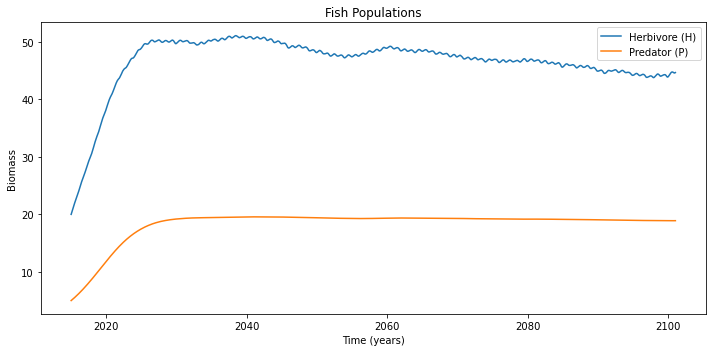

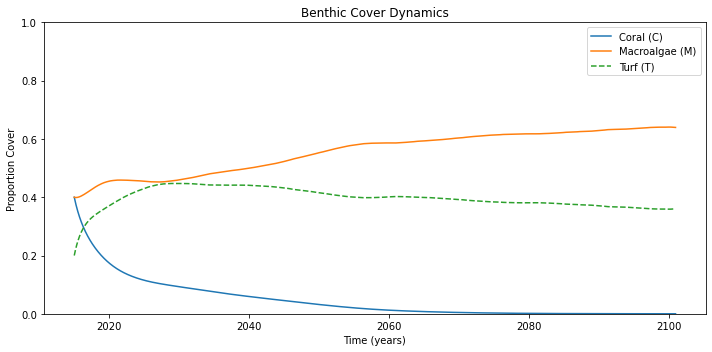

In [29]:
# Time axis (years)
START_YEAR = 2015
dt = parameters_dict["dt"]  # 1/12
t_years = START_YEAR + np.arange(len(C_array)) * dt


# Compute turf 
F_array = 1.0 - C_array - M_array

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(t_years, H_array, label='Herbivore (H)')
ax1.plot(t_years, P_array, label='Predator (P)')

ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Biomass")
ax1.legend()
ax1.set_title("Fish Populations")

plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(t_years, C_array, label='Coral (C)')
ax2.plot(t_years, M_array, label='Macroalgae (M)')
ax2.plot(t_years, F_array, label='Turf (T)', linestyle='--')

ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Proportion Cover")
ax2.set_ylim(0, 1)   # important since these are proportions
ax2.legend()
ax2.set_title("Benthic Cover Dynamics")

plt.tight_layout()
plt.show()

In [31]:
def load_T_series(csv_path, start_year=2015, end_year=2100, dt=1/12):
    """
    Reads a CSV with columns ['decimal_year','sst'] and returns T_series length nsteps+1
    for monthly stepping from start_year..end_year inclusive.
    """
    df = pd.read_csv(csv_path).dropna(subset=["decimal_year", "sst"]).sort_values("decimal_year")
    T_monthly = df["sst"].to_numpy(dtype=float)

    n_years = end_year - start_year + 1
    nsteps = n_years * 12  # monthly steps

    if len(T_monthly) == nsteps:
        T_series = np.concatenate([T_monthly, [T_monthly[-1]]])  # pad final state
    elif len(T_monthly) == nsteps + 1:
        T_series = T_monthly
    else:
        raise ValueError(
            f"{csv_path}: expected {nsteps} or {nsteps+1} monthly SST values for "
            f"{start_year}-{end_year}, but found {len(T_monthly)}"
        )

    numyears = nsteps * dt
    return T_series, numyears, dt, nsteps

In [32]:
def make_parameters_dict(T_series, numyears, dt,
                         r_H=0.4, K_H=100, e=0.01, g_H=0.0065, c=0.4, d=50, m_H=0.1, q_H=1.0, E_H=0.0,
                         r_P=0.2, K_P=10, b=0.4, m_P=0.01, q_P=1.0, E_P=0.0,
                         r_C=1.0, a=0.1, d_C=0.44,
                         r_M=0.8,
                         T_ref=25.0, A_mH=10430.0):
    return {
        "numyears": float(numyears),
        "dt": float(dt),

        # Temperature forcing
        "T_series": T_series,
        "T_ref": T_ref,
        "A_mH": A_mH,

        # Herbivore
        "r_H": r_H, "K_H": K_H, "e": e, "g_H": g_H, "c": c, "d": d,
        "m_H": m_H, "q_H": q_H, "E_H": E_H,

        # Predator
        "r_P": r_P, "K_P": K_P, "b": b,
        "m_P": m_P, "q_P": q_P, "E_P": E_P,

        # Coral
        "r_C": r_C, "a": a, "d_C": d_C,

        # Macroalgae
        "r_M": r_M,
    }

In [33]:
# Scenario CSVs (adjust names if yours differ)
scenario_files = {
    "SSP1-2.6": "sst_timeseries_ssp126.csv",
    "SSP2-4.5": "sst_timeseries_ssp245.csv",
    "SSP3-7.0": "sst_timeseries_ssp370.csv",
}

START_YEAR, END_YEAR = 2015, 2100
dt = 1/12

# Initial conditions
H0, P0, C0, M0 = 20, 5, 0.40, 0.40

outputs = {}

for scen, csv_path in scenario_files.items():
    T_series, numyears, dt_used, nsteps = load_T_series(csv_path, START_YEAR, END_YEAR, dt=dt)
    params = make_parameters_dict(T_series, numyears, dt_used)

    H_array, P_array, C_array, M_array, H_harv, P_harv = run_model(H0, P0, C0, M0, params)

    outputs[scen] = {
        "params": params,
        "H": H_array,
        "P": P_array,
        "C": C_array,
        "M": M_array,
        "H_harv": H_harv,
        "P_harv": P_harv,
    }

# Build a common time axis in calendar years
t_years = START_YEAR + np.arange(len(next(iter(outputs.values()))["H"])) * dt
print("End year ~", t_years[-1])

End year ~ 2101.0


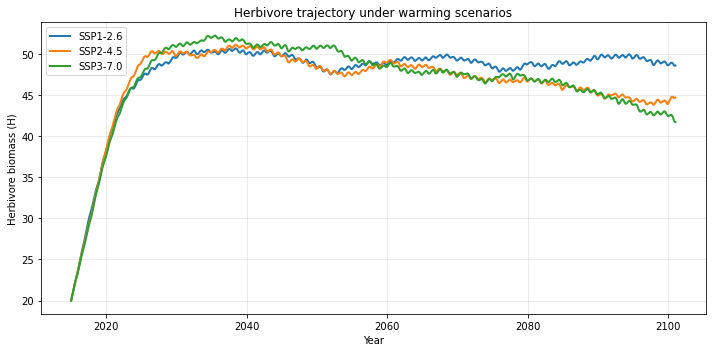

In [36]:
plt.figure(figsize=(10, 5))

for scen in ["SSP1-2.6", "SSP2-4.5", "SSP3-7.0"]:
    H = outputs[scen]["H"]
    plt.plot(t_years, H, label=scen, linewidth=2)

plt.xlabel("Year")
plt.ylabel("Herbivore biomass (H)")
plt.title("Herbivore trajectory under warming scenarios")
plt.grid(True, alpha=0.3)
plt.legend()

# Optional: zoom y-limits automatically
#all_H = np.concatenate([outputs[s]["H"] for s in outputs])
#plt.ylim(all_H.min() * 0.95, all_H.max() * 1.05)

plt.tight_layout()
plt.show()

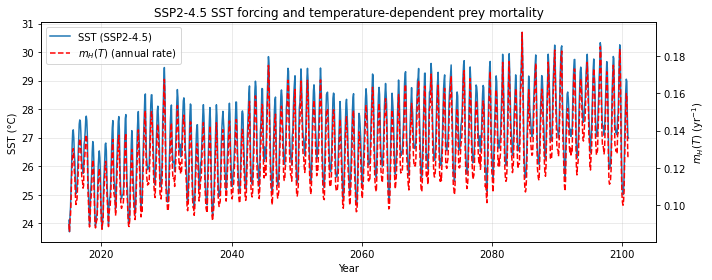

SST range: 23.70094 to 30.689224
m_H(T) range: 0.08580544736602114 to 0.19251930106330836


In [22]:
# --- Load SSP245 monthly SST ---
dfT = pd.read_csv("sst_timeseries_ssp245.csv").dropna()
T_monthly = dfT["sst"].to_numpy(dtype=float)

# --- Build T_series exactly like your model setup (2015–2100 monthly) ---
dt = 1/12
START_YEAR, END_YEAR = 2015, 2100
nsteps = (END_YEAR - START_YEAR + 1) * 12  # 1032

if len(T_monthly) == nsteps:
    T_series = np.concatenate([T_monthly, [T_monthly[-1]]])  # pad one step
elif len(T_monthly) == nsteps + 1:
    T_series = T_monthly
else:
    raise ValueError(f"Expected {nsteps} or {nsteps+1} points, got {len(T_monthly)}")

# --- Temperature-dependent mortality multiplier (relative to T_ref) ---
def arrhenius_mort_multiplier(T, T_ref=25.0, A=10430.0):
    T = np.asarray(T, dtype=float)
    return np.exp(A * (1.0/(T_ref + 273.15) - 1.0/(T + 273.15)))

# --- Compute m_H(t) ---
m_H0 = parameters_dict["m_H"]               # baseline annual mortality at T_ref
T_ref = parameters_dict.get("T_ref", 25.0)
A_mH  = parameters_dict.get("A_mH", 10430.0)

mH_series = m_H0 * arrhenius_mort_multiplier(T_series, T_ref=T_ref, A=A_mH)

# --- Build a simple monthly time axis for plotting ---
years = START_YEAR + np.arange(len(T_series)) * dt  # decimal years

# --- Overlay plot ---
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(years, T_series, label="SST (SSP2-4.5)")
ax1.set_xlabel("Year")
ax1.set_ylabel("SST (°C)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(years, mH_series, linestyle="--", label=r"$m_H(T)$ (annual rate)", color="red")
ax2.set_ylabel(r"$m_H(T)$ (yr$^{-1}$)")

# One combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("SSP2-4.5 SST forcing and temperature-dependent prey mortality")
plt.tight_layout()
plt.show()

print("SST range:", float(np.nanmin(T_series)), "to", float(np.nanmax(T_series)))
print("m_H(T) range:", float(np.nanmin(mH_series)), "to", float(np.nanmax(mH_series)))

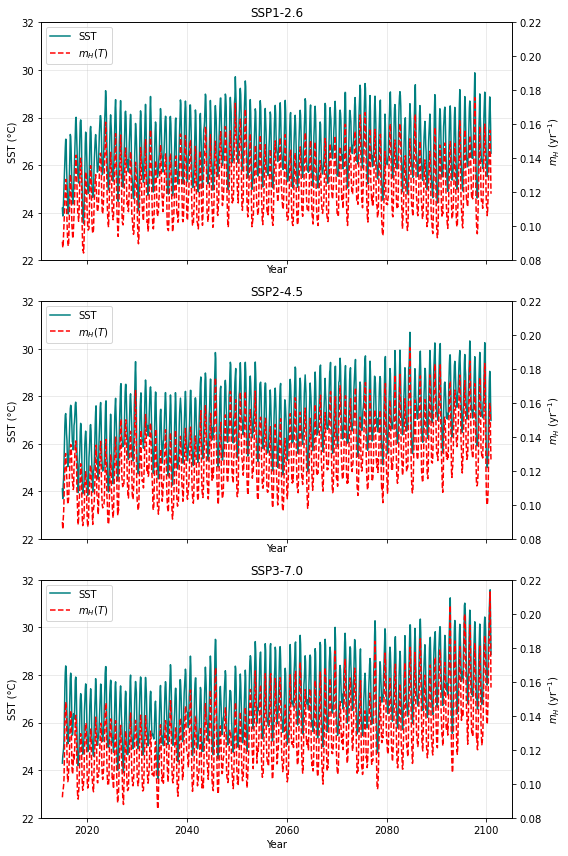

In [28]:
def arrhenius_mort_multiplier(T, T_ref=25.0, A=10430.0):
    T = np.asarray(T, dtype=float)
    return np.exp(A * (1.0/(T_ref + 273.15) - 1.0/(T + 273.15)))

# --- Files for each scenario ---
files = {
    "SSP1-2.6": "sst_timeseries_ssp126.csv",
    "SSP2-4.5": "sst_timeseries_ssp245.csv",
    "SSP3-7.0": "sst_timeseries_ssp370.csv",
}

# --- Mortality parameters from your model ---
m_H0 = parameters_dict["m_H"]               # baseline annual mortality at T_ref
T_ref = parameters_dict.get("T_ref", 25.0)
A_mH  = parameters_dict.get("A_mH", 10430.0)

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for ax, (label, path) in zip(axes, files.items()):
    df = pd.read_csv(path).dropna(subset=["decimal_year", "sst"]).sort_values("decimal_year")
    years = df["decimal_year"].to_numpy(dtype=float)
    T = df["sst"].to_numpy(dtype=float)

    mH = m_H0 * arrhenius_mort_multiplier(T, T_ref=T_ref, A=A_mH)

    # Left axis: SST
    ax.plot(years, T, label="SST", color="teal")
    ax.set_title(label)
    ax.set_xlabel("Year")
    ax.set_ylabel("SST (°C)")
    ax.set_ylim(22,32)
    ax.grid(True, alpha=0.3)

    # Right axis: mH(T)
    axr = ax.twinx()
    axr.plot(years, mH, linestyle="--", label=r"$m_H(T)$", color="red")
    axr.set_ylim(0.08,0.22)
    axr.set_ylabel(r"$m_H$ (yr$^{-1}$)")

    # Combined legend per panel
    l1, lab1 = ax.get_legend_handles_labels()
    l2, lab2 = axr.get_legend_handles_labels()
    ax.legend(l1 + l2, lab1 + lab2, loc="upper left")

plt.tight_layout()
plt.show()

## Temperature dependent mortality function

In [3]:
def arrhenius_mort_multiplier(T, T_ref=25.0, A=10430.0):
    """
    Returns a multiplicative factor relative to T_ref.
    f(T_ref) = 1
    """
    T = np.asarray(T, dtype=float)
    return np.exp(A * (1.0/(T_ref + 273.15) - 1.0/(T + 273.15)))

## Defining equations

In [4]:
def dNdt(H, P, C, M, parameters_dict, t_idx):
    # --- Herbivore parameters ---
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    e   = parameters_dict['e']
    g_H = parameters_dict['g_H']
    c   = parameters_dict['c']
    d   = parameters_dict['d']

    m_H0 = parameters_dict['m_H']      # baseline prey mortality at T_ref
    q_H  = parameters_dict['q_H']
    E_H  = parameters_dict['E_H']

    # --- Predator parameters ---
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b   = parameters_dict['b']
    m_P = parameters_dict['m_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']

    # --- Coral parameters ---
    r_C = parameters_dict['r_C']
    a   = parameters_dict['a']
    d_C = parameters_dict['d_C']

    # --- Macroalgae parameters ---
    r_M = parameters_dict['r_M']

    # --- Temperature forcing ---
    # Provide this in parameters_dict as an array aligned to your timestep
    T_series = parameters_dict['T_series']
    T = float(T_series[t_idx])

    # Temperature-dependent prey mortality
    T_ref = parameters_dict.get("T_ref", 25.0)
    A_mH  = parameters_dict.get("A_mH", 10430.0)
    m_H_eff = m_H0 * arrhenius_mort_multiplier(T, T_ref=T_ref, A=A_mH)

    # Derive terms
    F = 1.0 - C - M

    # IMPORTANT: I kept your exact algebra, but fixed parentheses on the (e*g_H*M)/(M+F) term
    # Your original line: ((e*g_H*M)/M+F)  -> due to precedence this becomes (e*g_H*M)/M + F
    # Most models intend: (e*g_H*M)/(M+F)
    grazing_gain = (e * g_H * M) / (M + F)

    dH = (r_H * H * (1 - H / K_H) + grazing_gain * (1 - H / K_H) - (c * H * P) / (d + H) - m_H_eff * H - q_H * E_H * H
    )

    dP = (r_P * P * (1 - P / K_P)+ (b * H * P) / (d + H)- m_P * P - q_P * E_P * P
    )

    dC = r_C * C * (1 - C - M) - a * C * M - d_C * C
    dM = r_M * M * (1 - C - M) + a * C * M - g_H * H * M / (M + F)

    return dH, dP, dC, dM, m_H_eff  # returning m_H_eff is optional (useful for debugging)

In [5]:
def RK2(H, P, C, M, parameters_dict, t_idx):
    dt = parameters_dict.get('dt', 1.0)

    dH1, dP1, dC1, dM1, _mH1 = dNdt(H, P, C, M, parameters_dict, t_idx)

    H1 = H + 0.5 * dt * dH1
    P1 = P + 0.5 * dt * dP1
    C1 = C + 0.5 * dt * dC1
    M1 = M + 0.5 * dt * dM1

    dH2, dP2, dC2, dM2, _mH2 = dNdt(H1, P1, C1, M1, parameters_dict, t_idx)

    H = H + dt * 0.5 * (dH1 + dH2)
    P = P + dt * 0.5 * (dP1 + dP2)
    C = C + dt * 0.5 * (dC1 + dC2)
    M = M + dt * 0.5 * (dM1 + dM2)

    # enforce bounds
    H = max(H, 0.0)
    P = max(P, 0.0)
    C = min(max(C, 0.0), 1.0)
    M = min(max(M, 0.0), 1.0)

    q_H = parameters_dict['q_H']; E_H = parameters_dict['E_H']
    q_P = parameters_dict['q_P']; E_P = parameters_dict['E_P']

    herbivore_harvest = q_H * E_H * H
    predator_harvest  = q_P * E_P * P

    return H, P, C, M, herbivore_harvest, predator_harvest

In [6]:
# Function to run the model 

def run_model(INIT_H, INIT_P, INIT_C, INIT_M, parameters_dict):
    numyears = parameters_dict['numyears']

    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    C_array = np.zeros(numyears+1)
    M_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)

    # Optional: record effective mortality through time
    mH_eff_array = np.zeros(numyears+1)

    H_array[0] = INIT_H
    P_array[0] = INIT_P
    C_array[0] = INIT_C
    M_array[0] = INIT_M

    for i in range(numyears):
        H_array[i+1], P_array[i+1], C_array[i+1], M_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] = \
            RK2(H_array[i], P_array[i], C_array[i], M_array[i], parameters_dict, t_idx=i)

        # compute and store m_H_eff for diagnostics (uses state at i, but that’s fine)
        T = float(parameters_dict["T_series"][i])
        mH_eff_array[i] = parameters_dict["m_H"] * arrhenius_mort_multiplier(T, parameters_dict.get("T_ref", 25.0), parameters_dict.get("A_mH", 10430.0))

    # last value
    T_last = float(parameters_dict["T_series"][numyears])
    mH_eff_array[numyears] = parameters_dict["m_H"] * arrhenius_mort_multiplier(T_last, parameters_dict.get("T_ref", 25.0), parameters_dict.get("A_mH", 10430.0))

    return H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array, mH_eff_array

## Test Run

In [7]:
df = pd.read_csv("sst_timeseries_ssp245.csv")  # example
T_series = df["sst"].values  # or if using anomaly, add climatology or baseline

In [8]:
# Define default parameters
years = 100
dt = 0.01

default_params = {
    'numyears': int(years / dt),   # convert years to steps
    'dt': dt,
    'T_series': T_series,

    # Herbivore
    'r_H': 0.4,
    'K_H': 100,
    'e': 0.01,
    'g_H': 0.0065,
    'c': 0.4,
    'd': 50,
    'm_H': 0.1,
    'q_H': 1.0,
    'E_H': 0.0,

    # Predator
    'r_P': 0.2,
    'K_P': 10,
    'b': 0.4,
    'm_P': 0.01,
    'q_P': 1.0,
    'E_P': 0.0,

    # Coral
    'r_C': 1.0,
    'a': 0.1,
    'd_C': 0.44,

    # Macroalgae
    'r_M': 0.8,
}

In [9]:
# Run model simulation
numyears = 10000  # years (your RK2/run_model likely uses dt = 1 year per step)
dt = 0.01

# Herbivore parameters:
r_H = 0.4        # from supermodel 
K_H = 100        # from supermodel 
e = 0.01          # from cook et al. 2024 - not using currently 
g_H = 0.0065       # from mumby et al. 2007 #smaller than 0.01 = macroalgae dominated; greater = coral dominated
c = 0.4          # from supermodel 
d = 50           # from supermodel
m_H = 0.1        # frp, supermodel
q_H = 1.0        # same as always
E_H = 0.0        # varied

# Predator parameters:
r_P = 0.2        # from supermodel
K_P = 10         # from supermodel
b = 0.4          # from supermodel
m_P = 0.01       # from supermodel
q_P = 1.0        # same as always
E_P = 0.0        # varied

# Coral parameters:
r_C = 1.0        # blackwood et al. 
a = 0.1          # blackwood et al.
d_C = 0.44       # blackwood et al. 

# Algae parameters:
r_M = 0.8        # blackwood et al. 

parameters_dict = {
    'numyears': numyears,
    'dt': dt,

    # Herbivore
    'r_H': r_H,
    'K_H': K_H,
    'e': e,
    'g_H': g_H,
    'c': c,
    'd': d,
    'm_H': m_H,
    'q_H': q_H,
    'E_H': E_H,
    # Predator
    'r_P': r_P,
    'K_P': K_P,
    'b': b,
    'm_P': m_P,
    'q_P': q_P,
    'E_P': E_P,
    # Coral
    'r_C': r_C,
    'a': a,
    'd_C': d_C,
    # Algae
    'r_M': r_M,
}


In [10]:
# Initial conditions (scaled)
H0 = 20   # herbivore
P0 = 5   # predator 
C0 = 0.40   # coral cover
M0 = 0.40   # macroalgae cover

H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array = run_model(
    H0, P0, C0, M0, parameters_dict
)

KeyError: 'T_series'

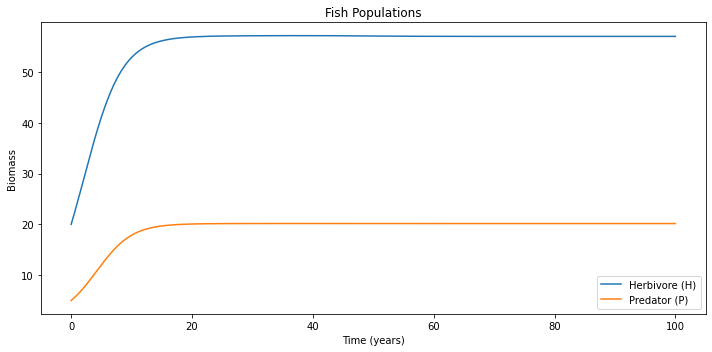

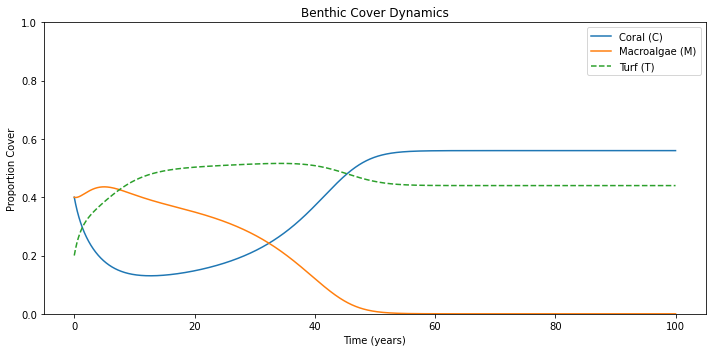

In [11]:
# Time axis (years)
t_years = np.arange(len(C_array)) * default_params["dt"]


# Compute turf 
F_array = 1.0 - C_array - M_array

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(t_years, H_array, label='Herbivore (H)')
ax1.plot(t_years, P_array, label='Predator (P)')

ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Biomass")
ax1.legend()
ax1.set_title("Fish Populations")

plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(t_years, C_array, label='Coral (C)')
ax2.plot(t_years, M_array, label='Macroalgae (M)')
ax2.plot(t_years, F_array, label='Turf (T)', linestyle='--')

ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Proportion Cover")
ax2.set_ylim(0, 1)   # important since these are proportions
ax2.legend()
ax2.set_title("Benthic Cover Dynamics")

plt.tight_layout()
plt.show()

## Sensitivity Analysis

#### Define default parameters and setup sweeps

In [222]:
# Define default parameters
years = 100
dt = 0.01

default_params = {
    'numyears': int(years / dt),   # convert years to steps
    'dt': dt,

    # Herbivore
    'r_H': 0.4,
    'K_H': 100,
    'e': 0.01,
    'g_H': 0.0065,
    'c': 0.4,
    'd': 50,
    'm_H': 0.1,
    'q_H': 1.0,
    'E_H': 0.0,

    # Predator
    'r_P': 0.2,
    'K_P': 10,
    'b': 0.4,
    'm_P': 0.01,
    'q_P': 1.0,
    'E_P': 0.0,

    # Coral
    'r_C': 1.0,
    'a': 0.1,
    'd_C': 0.44,

    # Macroalgae
    'r_M': 0.8,
}

# Setup parameter sweeps (+/- 25%)

pct = 0.25
npts = 50

param_sweeps = {}
for k, p0 in default_params.items():
    if k in ("numyears", "dt"):
        continue  # don't sweep integration settings
    lo = p0 * (1 - pct)
    hi = p0 * (1 + pct)
    param_sweeps[k] = np.linspace(lo, hi, npts)
    
# Optional: remove parameters that don't change (e.g., default = 0)
param_sweeps = {
    k: v for k, v in param_sweeps.items()
    if not np.allclose(v, v[1])
}

# Define function to run sweeps
# Run for 100 yrs - report avg. of last 10 years

def compute_benthic_sensitivity_data(
    param_name,
    param_vals,
    fixed_params,
    H0, P0, C0, M0,
    sample_window_years=10,
):

    C_means = []
    M_means = []
    T_means = []

    dt = fixed_params["dt"]
    sample_window = int(sample_window_years / dt)
    sample_window = max(5, sample_window)

    for val in param_vals:
        params = fixed_params.copy()
        params[param_name] = val

        H_array, P_array, C_array, M_array, *_ = run_model(
            H0, P0, C0, M0, params
        )

        C_tail = C_array[-sample_window:]
        M_tail = M_array[-sample_window:]
        T_tail = 1.0 - C_tail - M_tail

        C_means.append(np.mean(C_tail))
        M_means.append(np.mean(M_tail))
        T_means.append(np.mean(T_tail))

    return {
        "param_vals": np.array(param_vals),
        "C_means": np.array(C_means),
        "M_means": np.array(M_means),
        "T_means": np.array(T_means),
    }

Sensitivity analysis complete.


#### Run analysis

In [ ]:
H0 = 20
P0 = 5
C0 = 0.40
M0 = 0.40

results = {}

for param_name, param_vals in param_sweeps.items():
    results[param_name] = compute_benthic_sensitivity_data(
        param_name,
        param_vals,
        default_params,
        H0, P0, C0, M0,
        sample_window_years=10,
    )

print("Sensitivity analysis complete.")

#### Set up plotting scheme

In [226]:
def plot_benthic_sensitivity_small_multiples(
    results,
    default_params,
    pct,
    latex_labels=None,
    ncols=4,
    figsize=(14, 11),      # good starting size for 17 panels
    show_legend_once=True,
    turf_label="T",
    title_wrap=14,
):
    params = list(results.keys())
    n = len(params)
    nrows = math.ceil(n / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    axs = np.array(axs).reshape(-1)

    xticks = [1 - pct, 1.0, 1 + pct]
    xticklabels = [f"-{int(pct*100)}%", "default", f"+{int(pct*100)}%"]

    for i, p in enumerate(params):
        ax = axs[i]
        data = results[p]

        x = np.array(data["param_vals"], dtype=float)
        p0 = default_params[p]
        x_rel = x / p0 if p0 != 0 else np.full_like(x, np.nan)

        ax.plot(x_rel, data["C_means"], label="C*")
        ax.plot(x_rel, data["M_means"], label="M*")
        ax.plot(x_rel, data["T_means"], label=f"{turf_label}*")

        title = latex_labels.get(p, p) if latex_labels is not None else p
        title_wrapped = "\n".join(textwrap.wrap(title, width=title_wrap))
        ax.set_title(title_wrapped, fontsize=9, pad=6)

        ax.set_xlim(1 - pct, 1 + pct)
        ax.set_ylim(0, 1)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, fontsize=8)
        ax.tick_params(axis="y", labelsize=8)

        ax.grid(True, alpha=0.25)

        if (not show_legend_once) or (show_legend_once and i == 0):
            ax.legend(fontsize=8, frameon=False, loc="best")

    # hide unused panels
    for j in range(n, len(axs)):
        axs[j].axis("off")

    # Reserve margins for global labels:
    # left=0.10 gives room for y label; bottom=0.10 gives room for x label
    plt.tight_layout(rect=[0.05, 0.05, 0.995, 0.98])

    # Global labels placed in the reserved margin space
    fig.text(0.5, 0.04, "Percent Change (%) in Parameter", ha="center", fontsize=12)
    fig.text(0.04, 0.5, "Final Benthic Cover", va="center", rotation="vertical", fontsize=12)

    plt.show()

#### Plot output

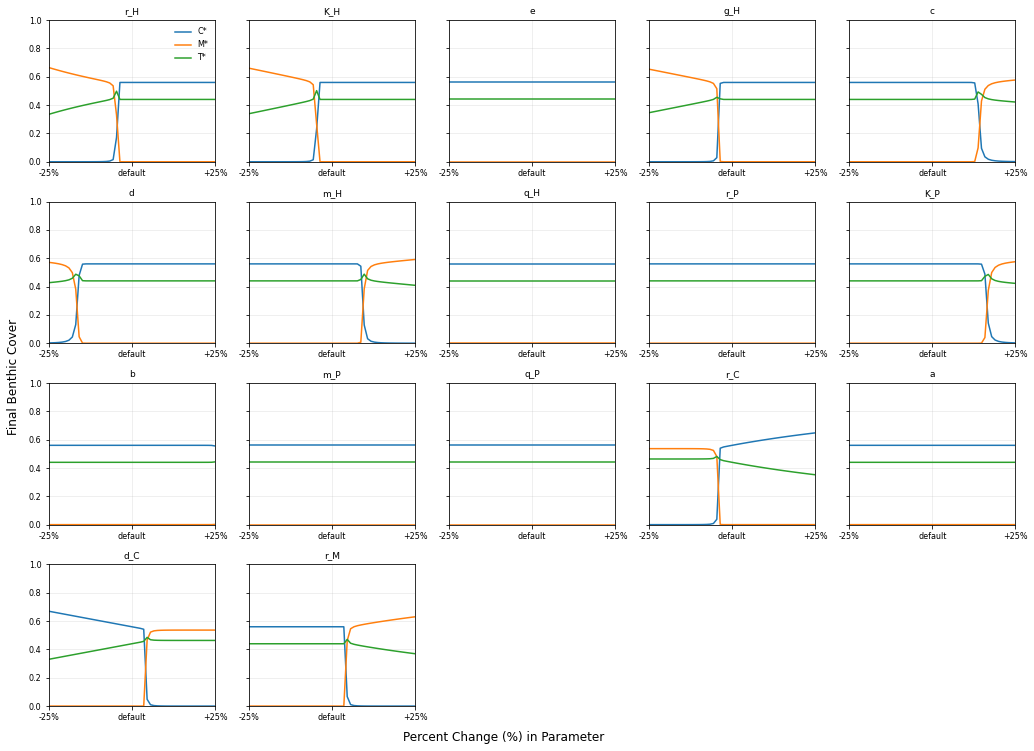

In [228]:
plot_benthic_sensitivity_small_multiples(
    results=results,
    default_params=default_params,
    pct=pct,
    latex_labels=None,
    ncols=5,
    figsize=(15, 11),
    turf_label="T",
)

### Checking for bistability

In [244]:
def classify_benthic_state(Cstar, Mstar, C_dom=0.4, M_dom=0.4, low_thr=0.1):
    """
    1 = coral-dominated
    2 = algae-dominated
    3 = mixed/other (coexistence/intermediate)
    """
    if (Cstar >= C_dom) and (Mstar <= low_thr):
        return 1
    if (Mstar >= M_dom) and (Cstar <= low_thr):
        return 2
    return 3

def steady_CM_from_run(H_array, P_array, C_array, M_array, dt, sample_window_years=10):
    w = max(5, int(sample_window_years / dt))
    C_tail = C_array[-w:]
    M_tail = M_array[-w:]
    T_tail = 1.0 - C_tail - M_tail
    return float(np.mean(C_tail)), float(np.mean(M_tail)), float(np.mean(T_tail))

def compute_bistability_1d(
    param_name,
    param_vals,
    fixed_params,
    init_coral,    # tuple (H0,P0,C0,M0)
    init_algae,    # tuple (H0,P0,C0,M0)
    sample_window_years=10,
    diff_tol=0.05,         # how different endpoints must be to call bistable
    C_dom=0.6, M_dom=0.6, low_thr=0.1
):
    """
    For each value of param_name:
      - run from coral IC and algae IC
      - compute steady C*, M*, T*
      - bistable if endpoints differ by > diff_tol in C* (or M*)

    Returns arrays so you can plot bistability intervals.
    """

    dt = fixed_params["dt"]

    Cc, Mc, Tc = [], [], []
    Ca, Ma, Ta = [], [], []

    state_c = []
    state_a = []
    bistable = []

    for val in param_vals:
        params = fixed_params.copy()
        params[param_name] = float(val)

        # coral IC run
        H0, P0, C0, M0 = init_coral
        H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
        Cstar_c, Mstar_c, Tstar_c = steady_CM_from_run(H, P, C, M, dt, sample_window_years)

        # algae IC run
        H0, P0, C0, M0 = init_algae
        H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
        Cstar_a, Mstar_a, Tstar_a = steady_CM_from_run(H, P, C, M, dt, sample_window_years)

        Cc.append(Cstar_c); Mc.append(Mstar_c); Tc.append(Tstar_c)
        Ca.append(Cstar_a); Ma.append(Mstar_a); Ta.append(Tstar_a)

        sc = classify_benthic_state(Cstar_c, Mstar_c, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr)
        sa = classify_benthic_state(Cstar_a, Mstar_a, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr)
        state_c.append(sc); state_a.append(sa)

        # bistability definition (endpoint difference)
        is_bistable = (abs(Cstar_c - Cstar_a) > diff_tol) or (abs(Mstar_c - Mstar_a) > diff_tol)
        bistable.append(is_bistable)

    return {
        "param_vals": np.array(param_vals),
        "C_coralIC": np.array(Cc),
        "M_coralIC": np.array(Mc),
        "T_coralIC": np.array(Tc),
        "C_algaeIC": np.array(Ca),
        "M_algaeIC": np.array(Ma),
        "T_algaeIC": np.array(Ta),
        "state_coralIC": np.array(state_c, dtype=int),
        "state_algaeIC": np.array(state_a, dtype=int),
        "bistable_mask": np.array(bistable, dtype=bool),
    }

In [245]:
# Two initial benthic states (same fish ICs)
init_coral = (H0, P0, 0.8, 0.1)
init_algae = (H0, P0, 0.1, 0.8)

bistability_results = {}

for param_name, param_vals in param_sweeps.items():
    bistability_results[param_name] = compute_bistability_1d(
        param_name=param_name,
        param_vals=param_vals,
        fixed_params=default_params,
        init_coral=init_coral,
        init_algae=init_algae,
        sample_window_years=10,
        diff_tol=0.05,     # tune if needed (0.02–0.1)
        C_dom=0.6, M_dom=0.6, low_thr=0.1
    )

print("Bistability scan complete.")

Bistability scan complete.


In [246]:
for p, d in bistability_results.items():
    if np.any(d["bistable_mask"]):
        idx = np.where(d["bistable_mask"])[0]
        print(p, "bistable over", len(idx), "of", len(d["param_vals"]), "values")

r_H bistable over 39 of 50 values
K_H bistable over 36 of 50 values
e bistable over 50 of 50 values
g_H bistable over 35 of 50 values
c bistable over 50 of 50 values
d bistable over 50 of 50 values
m_H bistable over 48 of 50 values
q_H bistable over 50 of 50 values
r_P bistable over 50 of 50 values
K_P bistable over 50 of 50 values
b bistable over 50 of 50 values
m_P bistable over 50 of 50 values
q_P bistable over 50 of 50 values
r_C bistable over 37 of 50 values
a bistable over 50 of 50 values
d_C bistable over 36 of 50 values
r_M bistable over 35 of 50 values


### Plot

In [247]:
def plot_bistability_small_multiples(
    bistability_results,
    default_params,
    pct,
    latex_labels=None,
    ncols=4,
    figsize=(16, 11),
    title_wrap=14,
    shade_alpha=0.12,
    show_legend_once=True,
    plot_vars=("C", "M", "T"),
):
    """
    bistability_results[param] must contain:
      - 'param_vals'
      - '{C,M,T}_coralIC'
      - '{C,M,T}_algaeIC'
      - 'bistable_mask' (bool)
    """

    params = list(bistability_results.keys())
    n = len(params)
    nrows = math.ceil(n / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    axs = np.array(axs).reshape(-1)

    xticks = [1 - pct, 1.0, 1 + pct]
    xticklabels = [f"-{int(pct*100)}%", "default", f"+{int(pct*100)}%"]

    def _shade_bistable(ax, x_rel, mask):
        """Shade contiguous regions where mask is True."""
        mask = np.asarray(mask, dtype=bool)
        if mask.sum() == 0:
            return
        # find contiguous True segments
        idx = np.where(mask)[0]
        # split into runs
        runs = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)
        for r in runs:
            ax.axvspan(x_rel[r[0]], x_rel[r[-1]], alpha=shade_alpha, color="k", linewidth=0)

    for i, p in enumerate(params):
        ax = axs[i]
        data = bistability_results[p]

        x = np.array(data["param_vals"], dtype=float)
        p0 = default_params[p]
        x_rel = x / p0 if p0 != 0 else np.full_like(x, np.nan)

        # Shade bistable region(s)
        _shade_bistable(ax, x_rel, data["bistable_mask"])

        # Plot variables
        if "C" in plot_vars:
            ax.plot(x_rel, data["C_coralIC"], label="C* coralIC", linewidth=1.6)
            ax.plot(x_rel, data["C_algaeIC"], linestyle="--", label="C* algaeIC", linewidth=1.6)

        if "M" in plot_vars:
            ax.plot(x_rel, data["M_coralIC"], label="M* coralIC", linewidth=1.6)
            ax.plot(x_rel, data["M_algaeIC"], linestyle="--", label="M* algaeIC", linewidth=1.6)

        if "T" in plot_vars:
            ax.plot(x_rel, data["T_coralIC"], label="T* coralIC", linewidth=1.6)
            ax.plot(x_rel, data["T_algaeIC"], linestyle="--", label="T* algaeIC", linewidth=1.6)

        # Title
        title = latex_labels.get(p, p) if latex_labels is not None else p
        ax.set_title("\n".join(textwrap.wrap(title, width=title_wrap)), fontsize=9, pad=6)

        # Axes formatting
        ax.set_xlim(1 - pct, 1 + pct)
        ax.set_ylim(0, 1)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, fontsize=8)
        ax.tick_params(axis="y", labelsize=8)
        ax.grid(True, alpha=0.25)

        if (not show_legend_once) or (show_legend_once and i == 0):
            ax.legend(fontsize=7, frameon=False, loc="best", ncol=1)

    # Hide unused panels
    for j in range(n, len(axs)):
        axs[j].axis("off")

    # Reserve margin space for global labels
    plt.tight_layout(rect=[0.10, 0.10, 0.995, 0.98])

    fig.text(0.5, 0.04, "Parameter value (relative to default)", ha="center", fontsize=12)
    fig.text(0.04, 0.5, "Steady benthic cover (mean of tail window)", va="center",
             rotation="vertical", fontsize=12)

    plt.show()


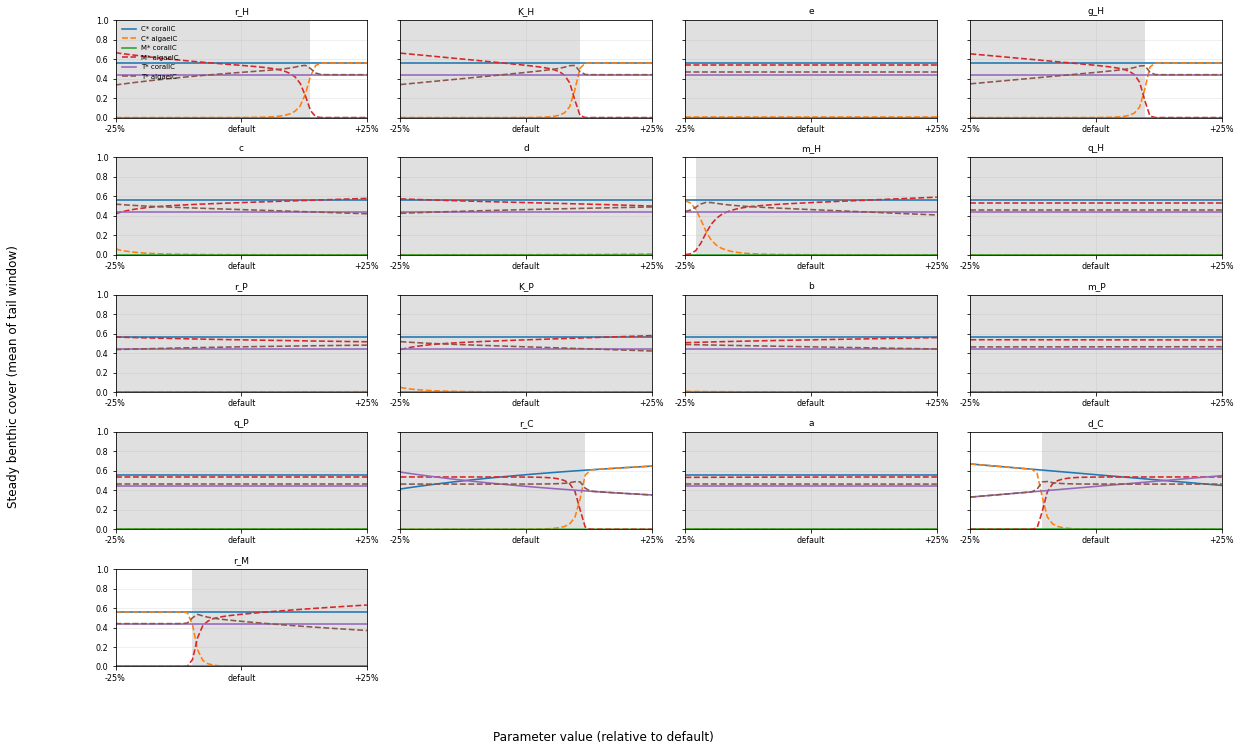

In [250]:
plot_bistability_small_multiples(
    bistability_results=bistability_results,
    default_params=default_params,
    pct=pct,            # e.g., 0.25
    latex_labels=None,
    ncols=4,
    figsize=(18, 11),
    plot_vars=("C", "M", "T"),
)

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def classify_endpoint(Cstar, Mstar, C_dom=0.6, M_dom=0.6, low_thr=0.1):
    # 1 coral-dom, 2 algae-dom, 3 coexist/mixed
    if (Cstar >= C_dom) and (Mstar <= low_thr):
        return 1
    if (Mstar >= M_dom) and (Cstar <= low_thr):
        return 2
    return 3

def basin_map_CM(params, H0=20, P0=5, grid_n=41, years_window=20, C_dom=0.6, M_dom=0.6, low_thr=0.1):
    dt = params["dt"]
    w = max(5, int(years_window / dt))

    # grid in the feasible triangle
    C_vals = np.linspace(0.0, 1.0, grid_n)
    M_vals = np.linspace(0.0, 1.0, grid_n)

    basin = np.full((grid_n, grid_n), np.nan)

    for i, C0 in enumerate(C_vals):
        for j, M0 in enumerate(M_vals):
            if C0 + M0 > 1.0:
                continue

            H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
            Cstar = float(np.mean(C[-w:]))
            Mstar = float(np.mean(M[-w:]))

            basin[j, i] = classify_endpoint(Cstar, Mstar, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr)
            # note basin indexed [j,i] so plot axes align (C horizontal, M vertical)

    return C_vals, M_vals, basin

def plot_basin_map(C_vals, M_vals, basin, title="Basin map"):
    cmap = ListedColormap(["royalblue", "seagreen", "lightgray"])  # coral, algae, mixed
    norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)

    plt.figure(figsize=(6,5))
    plt.imshow(
        basin,
        origin="lower",
        extent=[C_vals.min(), C_vals.max(), M_vals.min(), M_vals.max()],
        aspect="equal",
        cmap=cmap,
        norm=norm
    )

    # feasible boundary C+M=1
    x = np.linspace(0, 1, 200)
    plt.plot(x, 1-x, color="k", alpha=0.35)

    plt.xlabel("Initial coral, C0")
    plt.ylabel("Initial macroalgae, M0")
    plt.title(title)

    # manual legend
    import matplotlib.patches as mpatches
    plt.legend(handles=[
        mpatches.Patch(color="royalblue", label="Coral attractor"),
        mpatches.Patch(color="seagreen", label="Algae attractor"),
        mpatches.Patch(color="lightgray", label="Coexist/mixed"),
    ], loc="lower left", frameon=True)

    plt.tight_layout()
    plt.show()

In [252]:
params = dict(default_params)
params["g_H"] = 0.0065  # example
params["c"] = 0.4
params["b"] = 0.4

C_vals, M_vals, basin = basin_map_CM(params, grid_n=51, years_window=20)
plot_basin_map(C_vals, M_vals, basin, title="Basins of attraction (example params)")

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/op

KeyboardInterrupt: 

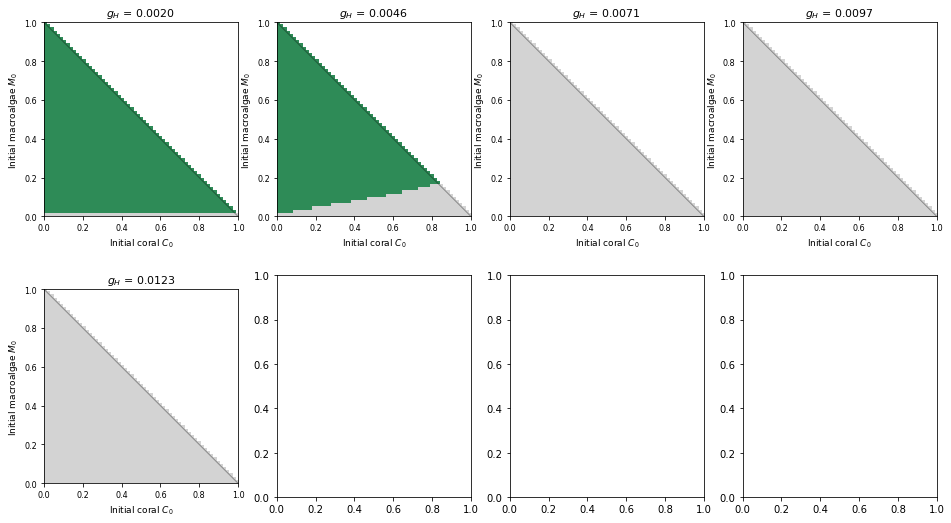

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import math

# -----------------------------
# Classification helpers
# -----------------------------
def classify_endpoint(Cstar, Mstar, C_dom=0.6, M_dom=0.6, low_thr=0.1):
    """
    1 = coral attractor (C high, M low)
    2 = macroalgae attractor (M high, C low)
    3 = mixed/coexistence (everything else)
    """
    if (Cstar >= C_dom) and (Mstar <= low_thr):
        return 1
    if (Mstar >= M_dom) and (Cstar <= low_thr):
        return 2
    return 3

def steady_CM(C_array, M_array, dt, window_years=20):
    w = max(5, int(window_years / dt))
    Cstar = float(np.mean(C_array[-w:]))
    Mstar = float(np.mean(M_array[-w:]))
    return Cstar, Mstar

# -----------------------------
# Basin map for a single g_H
# -----------------------------
def basin_map_for_gH(
    base_params,
    gH,
    H0=20, P0=5,
    grid_n=61,
    window_years=20,
    C_dom=0.6, M_dom=0.6, low_thr=0.1,
):
    """
    Returns:
      C_vals, M_vals: 1D grids (0..1)
      basin: 2D array with codes {1,2,3} (nan outside feasible triangle)
    """
    params = dict(base_params)
    params["g_H"] = float(gH)

    dt = params["dt"]
    C_vals = np.linspace(0.0, 1.0, grid_n)
    M_vals = np.linspace(0.0, 1.0, grid_n)

    basin = np.full((grid_n, grid_n), np.nan)

    for i, C0 in enumerate(C_vals):
        for j, M0 in enumerate(M_vals):
            if C0 + M0 > 1.0:
                continue

            H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
            Cstar, Mstar = steady_CM(C, M, dt, window_years=window_years)
            basin[j, i] = classify_endpoint(Cstar, Mstar, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr)

    return C_vals, M_vals, basin

# -----------------------------
# Plot multiple g_H panels
# -----------------------------
def plot_basin_maps_across_gH(
    base_params,
    gH_values,
    H0=20, P0=5,
    grid_n=61,
    window_years=20,
    C_dom=0.6, M_dom=0.6, low_thr=0.1,
    ncols=4,
    figsize=(16, 10),
):
    cmap = ListedColormap(["royalblue", "seagreen", "lightgray"])  # coral, algae, mixed
    norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)

    n = len(gH_values)
    nrows = math.ceil(n / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = np.array(axs).reshape(-1)

    for idx, gH in enumerate(gH_values):
        ax = axs[idx]
        C_vals, M_vals, basin = basin_map_for_gH(
            base_params, gH,
            H0=H0, P0=P0,
            grid_n=grid_n,
            window_years=window_years,
            C_dom=C_dom, M_dom=M_dom, low_thr=low_thr
        )

        ax.imshow(
            basin,
            origin="lower",
            extent=[C_vals.min(), C_vals.max(), M_vals.min(), M_vals.max()],
            aspect="equal",
            cmap=cmap,
            norm=norm,
        )

        # feasible boundary C+M=1
        x = np.linspace(0, 1, 200)
        ax.plot(x, 1-x, color="k", alpha=0.35, linewidth=1.0)

        ax.set_title(rf"$g_H$ = {gH:.4f}", fontsize=11)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        ax.set_xlabel("Initial coral $C_0$", fontsize=9)
        ax.set_ylabel("Initial macroalgae $M_0$", fontsize=9)
        ax.tick_params(labelsize=8)

    # Hide unused axes
    for j in range(n, len(axs)):
        axs[j].axis("off")

    # Legend
    legend_elements = [
        mpatches.Patch(color="royalblue", label="Coral attractor"),
        mpatches.Patch(color="seagreen", label="Macroalgae attractor"),
        mpatches.Patch(color="lightgray", label="Mixed/coexistence"),
    ]
    fig.legend(handles=legend_elements, loc="lower center", ncol=3, frameon=True, fontsize=11)

    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()

    return fig

# -----------------------------
# Example usage
# -----------------------------
# Pick a grazing range that spans low → intermediate → high
gH_values = np.linspace(0.002, 0.02, 8)   # adjust based on your system

plot_basin_maps_across_gH(
    base_params=default_params,
    gH_values=gH_values,
    H0=20, P0=5,
    grid_n=61,              # 41 for fast, 81 for nicer
    window_years=20,        # longer window = safer
    C_dom=0.6, M_dom=0.6, low_thr=0.1,
    ncols=4,
    figsize=(16, 9),
)

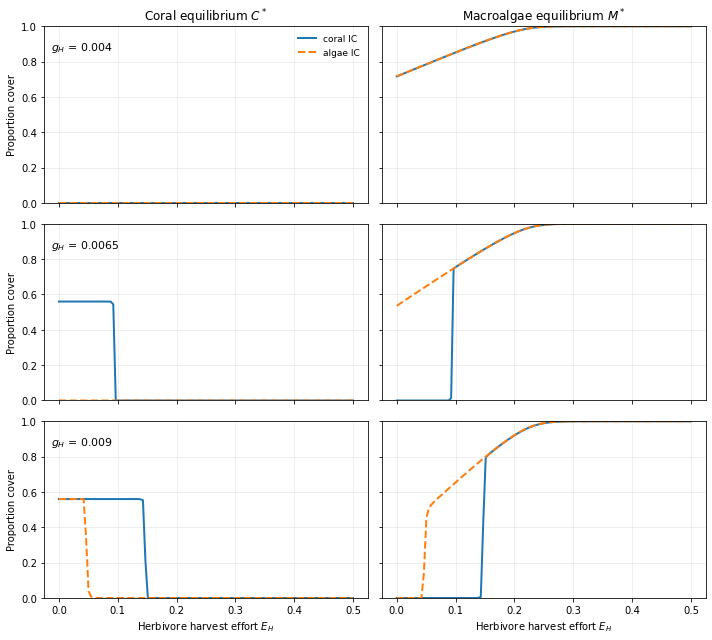

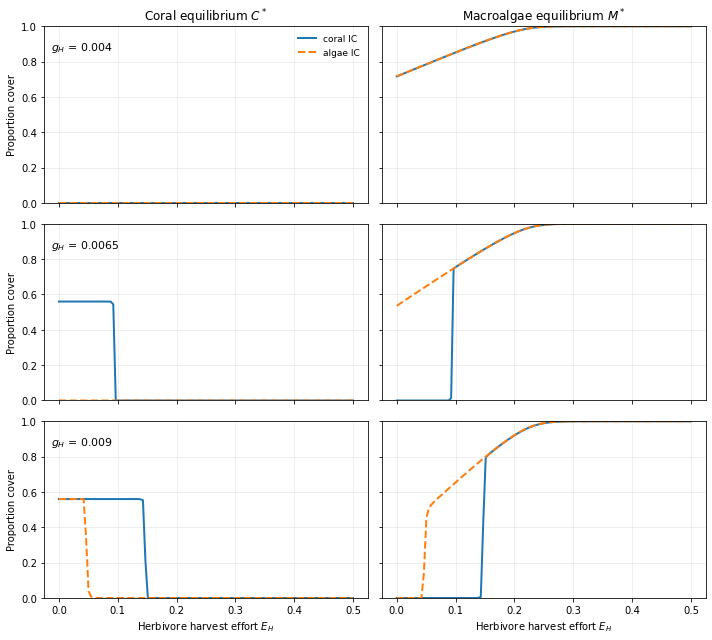

In [255]:
# -------------------------
# Helper: steady endpoints
# -------------------------
def steady_CM_from_run(C_array, M_array, dt, window_years=20):
    w = max(5, int(window_years / dt))
    Cstar = float(np.mean(C_array[-w:]))
    Mstar = float(np.mean(M_array[-w:]))
    return Cstar, Mstar

def sweep_EH_equilibria(
    base_params,
    EH_vals,
    gH_val,
    init_coral=(20, 5, 0.8, 0.1),
    init_algae=(20, 5, 0.1, 0.8),
    window_years=20,
):
    """
    Returns equilibrium curves for C* and M* under two initial conditions.
    """
    params = dict(base_params)
    params["g_H"] = float(gH_val)

    dt = params["dt"]

    C_coralIC, M_coralIC = [], []
    C_algaeIC, M_algaeIC = [], []

    for EH in EH_vals:
        params["E_H"] = float(EH)

        # coral IC
        H0, P0, C0, M0 = init_coral
        H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
        Cstar, Mstar = steady_CM_from_run(C, M, dt, window_years=window_years)
        C_coralIC.append(Cstar); M_coralIC.append(Mstar)

        # algae IC
        H0, P0, C0, M0 = init_algae
        H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
        Cstar, Mstar = steady_CM_from_run(C, M, dt, window_years=window_years)
        C_algaeIC.append(Cstar); M_algaeIC.append(Mstar)

    return {
        "EH": np.array(EH_vals),
        "C_coralIC": np.array(C_coralIC),
        "M_coralIC": np.array(M_coralIC),
        "C_algaeIC": np.array(C_algaeIC),
        "M_algaeIC": np.array(M_algaeIC),
    }

# -------------------------
# Plot: rows = grazing, cols = C* and M*
# -------------------------
def plot_equilibria_across_EH_by_grazing(
    base_params,
    gH_levels,
    EH_vals,
    init_coral=(20, 5, 0.8, 0.1),
    init_algae=(20, 5, 0.1, 0.8),
    window_years=20,
    figsize=(10, 9),
):
    nrows = len(gH_levels)
    fig, axs = plt.subplots(nrows, 2, figsize=figsize, sharex=True, sharey=True)

    if nrows == 1:
        axs = np.array([axs])

    for r, gH in enumerate(gH_levels):
        data = sweep_EH_equilibria(
            base_params=base_params,
            EH_vals=EH_vals,
            gH_val=gH,
            init_coral=init_coral,
            init_algae=init_algae,
            window_years=window_years,
        )

        # Left col: coral equilibrium
        axC = axs[r, 0]
        axC.plot(data["EH"], data["C_coralIC"], label="coral IC", linewidth=2)
        axC.plot(data["EH"], data["C_algaeIC"], linestyle="--", label="algae IC", linewidth=2)
        axC.set_ylabel("Proportion cover")

        # Right col: algae equilibrium
        axM = axs[r, 1]
        axM.plot(data["EH"], data["M_coralIC"], linewidth=2)
        axM.plot(data["EH"], data["M_algaeIC"], linestyle="--", linewidth=2)

        # Row label (grazing)
        axC.text(
            0.02, 0.92, rf"$g_H$ = {gH}",
            transform=axC.transAxes,
            fontsize=11,
            va="top"
        )

        # cosmetics
        axC.set_ylim(0, 1)
        axM.set_ylim(0, 1)
        axC.grid(True, alpha=0.25)
        axM.grid(True, alpha=0.25)

        if r == 0:
            axC.set_title(r"Coral equilibrium $C^*$")
            axM.set_title(r"Macroalgae equilibrium $M^*$")
            axC.legend(frameon=False, fontsize=9, loc="best")

    axs[-1, 0].set_xlabel(r"Herbivore harvest effort $E_H$")
    axs[-1, 1].set_xlabel(r"Herbivore harvest effort $E_H$")

    plt.tight_layout()
    plt.show()
    return fig

# -------------------------
# Example usage
# -------------------------

EH_vals = np.linspace(0.0, 0.5, 120)     # resolution of x-axis
gH_levels = [0.004, 0.0065, 0.009]       # rows (low/med/high grazing)

plot_equilibria_across_EH_by_grazing(
    base_params=default_params,
    gH_levels=gH_levels,
    EH_vals=EH_vals,
    init_coral=(20, 5, 0.8, 0.1),
    init_algae=(20, 5, 0.1, 0.8),
    window_years=20,
    figsize=(10, 9),
)

In [256]:

def warmstart_sweep_EH(
    base_params,
    EH_vals,
    gH_val,
    init_state=(20, 5, 0.8, 0.1),   # (H0,P0,C0,M0)
    window_years=20,
):
    """
    Sweep EH over EH_vals using warm-starting:
      each run starts from the previous run's final state.

    Returns arrays of steady C*, M* along the tracked branch.
    """
    params = dict(base_params)
    params["g_H"] = float(gH_val)
    dt = params["dt"]
    w = max(5, int(window_years / dt))

    H0, P0, C0, M0 = init_state

    Cstars = []
    Mstars = []

    for EH in EH_vals:
        params["E_H"] = float(EH)

        H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)

        # steady estimate from last window
        Cstar = float(np.mean(C[-w:]))
        Mstar = float(np.mean(M[-w:]))

        Cstars.append(Cstar)
        Mstars.append(Mstar)

        # warm start next run from final state
        H0 = float(H[-1])
        P0 = float(P[-1])
        C0 = float(C[-1])
        M0 = float(M[-1])

    return np.array(Cstars), np.array(Mstars)

In [259]:
def plot_hysteresis_equilibria_by_grazing(
    base_params,
    gH_levels,
    EH_min=0.0,
    EH_max=1.0,
    nEH=50,
    init_state=(20, 5, 0.8, 0.1),
    window_years=20,
    shade_tol=0.03,
    figsize=(10, 9),
):
    EH_forward = np.linspace(EH_min, EH_max, nEH)
    EH_backward = EH_forward[::-1]

    nrows = len(gH_levels)
    fig, axs = plt.subplots(nrows, 2, figsize=figsize, sharex=True, sharey=True)
    if nrows == 1:
        axs = np.array([axs])

    for r, gH in enumerate(gH_levels):

        # Forward sweep
        C_fwd, M_fwd = warmstart_sweep_EH(
            base_params=base_params,
            EH_vals=EH_forward,
            gH_val=gH,
            init_state=init_state,
            window_years=window_years,
        )

        # Backward sweep (warm-start from the final state of the forward run)
        # To do this cleanly, start backward from the last state of the forward endpoint:
        # We'll re-run the final forward step once to capture that final state.
        params_tmp = dict(base_params)
        params_tmp["g_H"] = float(gH)
        params_tmp["E_H"] = float(EH_forward[-1])

        H0, P0, C0, M0 = init_state
        H, P, C, M, *_ = run_model(H0, P0, C0, M0, params_tmp)
        init_back = (float(H[-1]), float(P[-1]), float(C[-1]), float(M[-1]))

        C_bwd, M_bwd = warmstart_sweep_EH(
            base_params=base_params,
            EH_vals=EH_backward,
            gH_val=gH,
            init_state=init_back,
            window_years=window_years,
        )
        # reverse bwd arrays to align with EH_forward axis
        C_bwd_plot = C_bwd[::-1]
        M_bwd_plot = M_bwd[::-1]

        # Detect hysteresis region (where sweeps differ)
        hyst_mask_C = np.abs(C_fwd - C_bwd_plot) > shade_tol
        hyst_mask_M = np.abs(M_fwd - M_bwd_plot) > shade_tol
        hyst_mask = hyst_mask_C | hyst_mask_M

        # ----- Coral panel -----
        axC = axs[r, 0]
        axC.plot(EH_forward, C_fwd, linewidth=2, label="forward")
        axC.plot(EH_forward, C_bwd_plot, linewidth=2, linestyle="--", label="backward")

        # Shade hysteresis window
        if np.any(hyst_mask):
            axC.fill_between(EH_forward, 0, 1, where=hyst_mask, color="0.8", alpha=0.5, transform=axC.get_xaxis_transform())

        # ----- Macroalgae panel -----
        axM = axs[r, 1]
        axM.plot(EH_forward, M_fwd, linewidth=2)
        axM.plot(EH_forward, M_bwd_plot, linewidth=2, linestyle="--")

        if np.any(hyst_mask):
            axM.fill_between(EH_forward, 0, 1, where=hyst_mask, color="0.8", alpha=0.5, transform=axM.get_xaxis_transform())

        # labels + row annotation
        axC.text(0.02, 0.92, rf"$g_H$ = {gH}", transform=axC.transAxes, fontsize=11, va="top")

        axC.set_ylim(0, 1)
        axM.set_ylim(0, 1)
        axC.grid(True, alpha=0.25)
        axM.grid(True, alpha=0.25)

        if r == 0:
            axC.set_title(r"Coral equilibrium $C^*$")
            axM.set_title(r"Macroalgae equilibrium $M^*$")
            axC.legend(frameon=False, fontsize=9, loc="best")

    axs[-1, 0].set_xlabel(r"Herbivore harvest effort $E_H$")
    axs[-1, 1].set_xlabel(r"Herbivore harvest effort $E_H$")
    for r in range(nrows):
        axs[r, 0].set_ylabel("Proportion cover")

    plt.tight_layout()
    plt.show()
    return fig

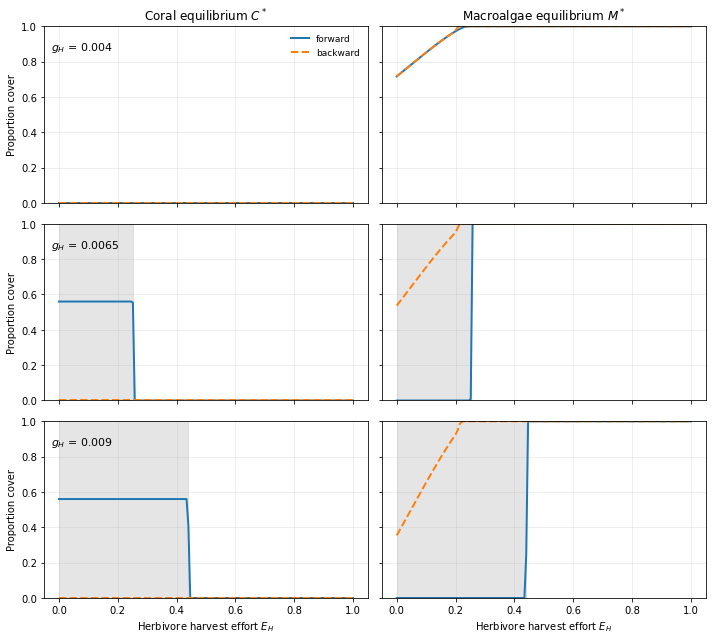

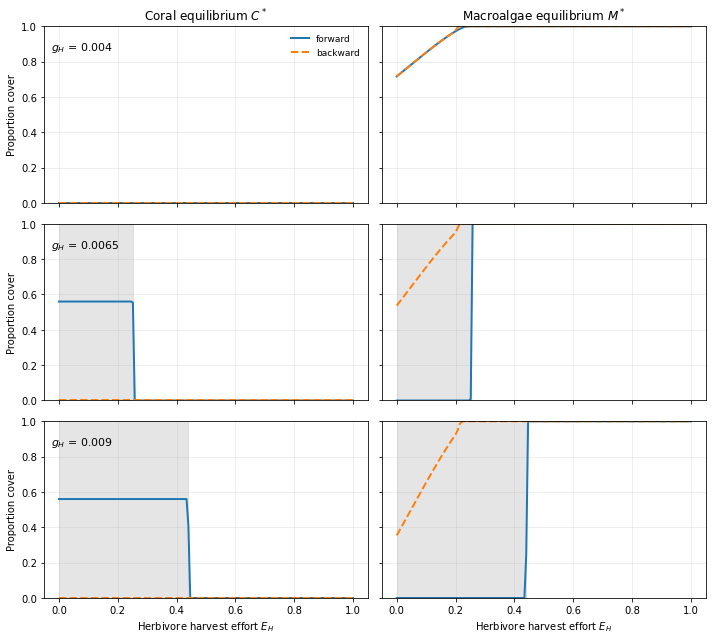

In [260]:
gH_levels = [0.004, 0.0065, 0.009]

plot_hysteresis_equilibria_by_grazing(
    base_params=default_params,
    gH_levels=gH_levels,
    EH_min=0.0,
    EH_max=1.0,
    nEH=160,
    init_state=(20, 5, 0.8, 0.1),  # single IC, paper-style
    window_years=20,
    shade_tol=0.03,
    figsize=(10, 9),
)

In [102]:
# ----------------------------
# Settings (edit these)
# ----------------------------
size = 50                  # start 150–250; 500 is heavy (500^2 = 250k sims per panel)
tail_years = 10             # steady window in years
b_array = np.linspace(0.0, 1.0, size)
c_array = np.linspace(0.0, 1.0, size)

grazing_levels = [0.005, 0.01, 0.02, 0.04]   # choose your low→high grazing slices

# Dominance thresholds (tune as needed)
C_dom = 0.6     # coral-dominated if C* >= 0.6
M_dom = 0.6     # algae-dominated if M* >= 0.6
low_thr = 0.1   # "low" threshold for the opposite state (optional)

# Initial conditions for bistability test
H0, P0 = 20, 5
init_coral = (H0, P0, 0.8, 0.1)
init_algae = (H0, P0, 0.1, 0.8)

# ----------------------------
# Helpers
# ----------------------------
def steady_endpoints_CM(params, init, tail_years=10):
    H0, P0, C0, M0 = init
    H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)

    dt = params["dt"]
    w = max(5, int(tail_years / dt))

    Cstar = float(np.mean(C[-w:]))
    Mstar = float(np.mean(M[-w:]))
    return Cstar, Mstar

def classify_dom_simple(Cc, Mc, Ca, Ma, C_dom=0.5, M_dom=0.5, tol=0.05):

    # Check dominance for each IC
    coralIC_is_coral = Cc >= C_dom
    coralIC_is_algae = Mc >= M_dom

    algaeIC_is_coral = Ca >= C_dom
    algaeIC_is_algae = Ma >= M_dom

    # Bistable if ICs lead to opposite dominance
    if coralIC_is_coral and algaeIC_is_algae:
        return 0   # bistable

    # Otherwise classify by coral IC outcome
    if coralIC_is_coral:
        return 1   # coral-only
    if coralIC_is_algae:
        return 2   # algae-only

    return 3       # coexistence

def compute_benthic_region_panel(base_params, g_H_val, b_array, c_array,
                                 init_coral, init_algae,
                                 tail_years=10, C_dom=0.6, M_dom=0.6, low_thr=0.1):
    """
    Returns region_data with codes:
      0 = bistable (coral IC -> coral-only AND algae IC -> algae-only)
      1 = coral-only (single attractor)
      2 = algae-only (single attractor)
      3 = mixed/other (single attractor but not clearly dominated)
    """

    region_data = np.zeros((len(b_array), len(c_array)), dtype=np.uint8)

    for i, b in enumerate(b_array):
        for j, c in enumerate(c_array):
            params = dict(base_params)
            params["g_H"] = float(g_H_val)
            params["b"] = float(b)
            params["c"] = float(c)

            # Run from two initial benthic states
            Cc, Mc = steady_endpoints_CM(params, init_coral, tail_years=tail_years)
            Ca, Ma = steady_endpoints_CM(params, init_algae, tail_years=tail_years)

            cls_coralIC = classify_dom(Cc, Mc, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr)
            cls_algaeIC = classify_dom(Ca, Ma, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr)

            # Bistability condition (strong form): different basins lead to different dominated states
            if (cls_coralIC == 1) and (cls_algaeIC == 2):
                region_data[i, j] = 0
            else:
                # if not bistable, label by which attractor you actually get from the coral IC
                # (you can choose algaeIC instead; just be consistent)
                region_data[i, j] = cls_coralIC

    return region_data

# ----------------------------
# Plotting (similar to your earlier layout)
# ----------------------------
def plot_grazing_panels(region_panels, b_array, c_array, grazing_levels):
    # 0=bistable, 1=coral-only, 2=algae-only, 3=mixed/other
    cmap = ListedColormap([
        "gold",        # 0 bistable
        "royalblue",   # 1 coral-only
        "seagreen",    # 2 algae-only
        "lightgray",   # 3 mixed/other
    ])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(14, 8))
    n = len(region_panels)

    # layout: 1 row if <=4, else 2 rows
    ncols = min(n, 4)
    nrows = int(np.ceil(n / ncols))
    gs = GridSpec(nrows, ncols, figure=fig)

    for idx, (gH, region) in enumerate(zip(grazing_levels, region_panels)):
        ax = fig.add_subplot(gs[idx // ncols, idx % ncols])
        im = ax.imshow(
            region,
            cmap=cmap, norm=norm,
            extent=[c_array.min(), c_array.max(), b_array.min(), b_array.max()],
            origin="lower",
            aspect="auto",
            alpha=0.9
        )
        ax.set_title(rf"$g_H$ = {gH}", fontsize=14)
        ax.set_xlabel(r"$c$")
        if idx % ncols == 0:
            ax.set_ylabel(r"$b$")

    legend_elements = [
        mpatches.Patch(color="royalblue", label="Coral-only"),
        mpatches.Patch(color="seagreen", label="Macroalgae-only"),
        mpatches.Patch(color="gold", label="Bistable"),
        mpatches.Patch(color="lightgray", label="Mixed/other"),
    ]
    fig.legend(handles=legend_elements, loc="lower center", ncol=4, frameon=True, fontsize=12)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()

    return fig


In [97]:
base_params = dict(default_params)

region_panels = []
for gH in grazing_levels:
    region = compute_benthic_region_panel(
        base_params, gH, b_array, c_array,
        init_coral=init_coral, init_algae=init_algae,
        tail_years=tail_years, C_dom=C_dom, M_dom=M_dom, low_thr=low_thr
    )
    region_panels.append(region)

plot_grazing_panels(region_panels, b_array, c_array, grazing_levels)

NameError: name 'ListedColormap' is not defined

In [100]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

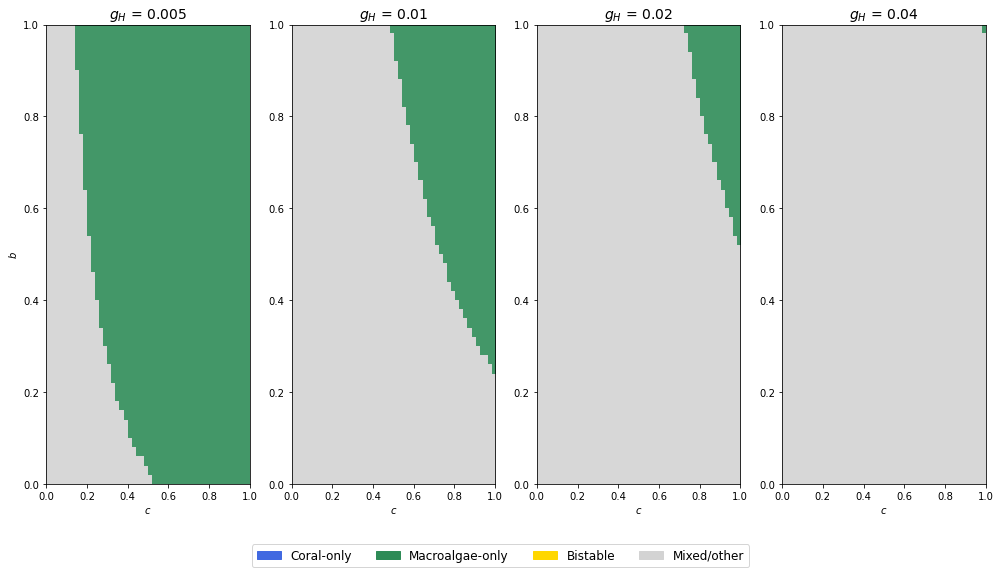

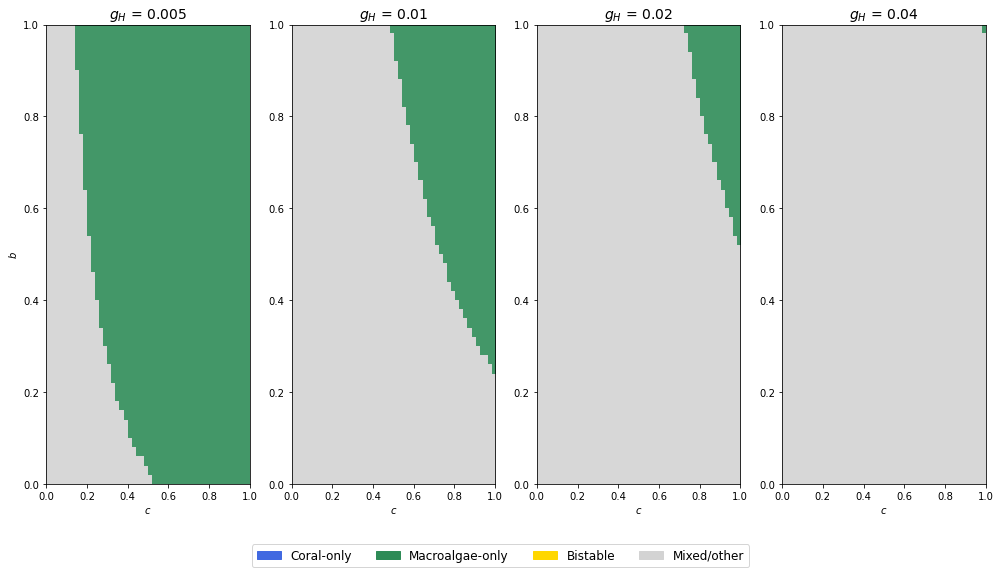

In [103]:
plot_grazing_panels(region_panels, b_array, c_array, grazing_levels)

In [90]:
def steady_CM(params, init, window_years=10):
    H0, P0, C0, M0 = init
    H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
    dt = params["dt"]
    w = max(5, int(window_years/dt))
    return np.mean(C[-w:]), np.mean(M[-w:])

def bistability_scan_2d(
    base_params,
    g_vals,
    b_vals,
    c_fixed,
    init_coral,
    init_algae,
    window_years=10,
    tol=0.05
):
    bistable_map = np.zeros((len(g_vals), len(b_vals)))

    for i, g in enumerate(g_vals):
        for j, b in enumerate(b_vals):
            p = dict(base_params)
            p["g_H"] = float(g)
            p["b"] = float(b)
            p["c"] = float(c_fixed)

            Cc, Mc = steady_CM(p, init_coral, window_years)
            Ca, Ma = steady_CM(p, init_algae, window_years)

            if abs(Cc - Ca) > tol:
                bistable_map[i, j] = 1  # bistable
            else:
                bistable_map[i, j] = 0  # single attractor

    return bistable_map

In [94]:
g_vals = np.linspace(0.001, 0.05, 20)
b_vals = np.linspace(0.1, 0.6, 20)
c_fixed = 0.4

init_coral = (20, 5, 0.8, 0.1)
init_algae = (20, 5, 0.1, 0.8)

bistable = bistability_scan_2d(
    default_params,
    g_vals,
    b_vals,
    c_fixed,
    init_coral,
    init_algae,
)

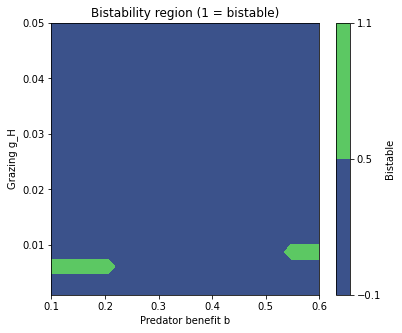

In [95]:
plt.figure(figsize=(6,5))
plt.contourf(b_vals, g_vals, bistable, levels=[-0.1,0.5,1.1])
plt.xlabel("Predator benefit b")
plt.ylabel("Grazing g_H")
plt.title("Bistability region (1 = bistable)")
plt.colorbar(label="Bistable")
plt.show()

In [55]:
def endpoint_CM(params, init, window_years=10):
    H0, P0, C0, M0 = init
    H, P, C, M, *_ = run_model(H0, P0, C0, M0, params)
    dt = params["dt"]
    w = max(5, int(window_years/dt))
    Cstar = np.mean(C[-w:])
    Mstar = np.mean(M[-w:])
    return Cstar, Mstar

def bistability_sweep_1d(base_params, param_name, values, init_coral, init_algae, window_years=10, tol=0.05):
    out = []
    for v in values:
        p = dict(base_params)
        p[param_name] = float(v)

        Cc, Mc = endpoint_CM(p, init_coral, window_years)
        Ca, Ma = endpoint_CM(p, init_algae, window_years)

        # simple bistability flag: endpoints differ by more than tol
        bistable = (abs(Cc - Ca) > tol) or (abs(Mc - Ma) > tol)

        out.append((v, Cc, Mc, Ca, Ma, bistable))
    return out

In [56]:
base = dict(default_params)

init_coral = (20, 5, 0.8, 0.1)
init_algae = (20, 5, 0.1, 0.8)

g_vals = np.linspace(0.001, 0.05, 40)

scan = bistability_sweep_1d(base, "g_H", g_vals, init_coral, init_algae, window_years=10, tol=0.05)

# Find g_H values that are bistable
bistable_vals = [row[0] for row in scan if row[-1]]
print("Bistable g_H values:", bistable_vals[:10], "... total:", len(bistable_vals))

Bistable g_H values: [0.007282051282051282] ... total: 1


## Sensistivity Analysis

In [198]:
import numpy as np

# =====================================================
# DEFAULT PARAMETERS
# =====================================================

years = 100
dt = 0.01

default_params = {
    'numyears': int(years / dt),   # convert years to steps
    'dt': dt,

    # Herbivore
    'r_H': 0.4,
    'K_H': 100,
    'e': 0.01,
    'g_H': 0.0065,
    'c': 0.4,
    'd': 50,
    'm_H': 0.1,
    'q_H': 1.0,
    'E_H': 0.0,

    # Predator
    'r_P': 0.2,
    'K_P': 10,
    'b': 0.4,
    'm_P': 0.01,
    'q_P': 1.0,
    'E_P': 0.0,

    # Coral
    'r_C': 1.0,
    'a': 0.1,
    'd_C': 0.44,

    # Macroalgae
    'r_M': 0.8,
}

# =====================================================
# PARAMETER SWEEPS (±20%)
# =====================================================

pct = 0.25
npts = 50

param_sweeps = {}
for k, p0 in default_params.items():
    if k in ("numyears", "dt"):
        continue  # don't sweep integration settings
    lo = p0 * (1 - pct)
    hi = p0 * (1 + pct)
    param_sweeps[k] = np.linspace(lo, hi, npts)
    
# Optional: remove parameters that don't change (e.g., default = 0)
param_sweeps = {
    k: v for k, v in param_sweeps.items()
    if not np.allclose(v, v[1])
}

# =====================================================
# BENTHIC SENSITIVITY FUNCTION (NO CYCLE TESTING)
# =====================================================

def compute_benthic_sensitivity_data(
    param_name,
    param_vals,
    fixed_params,
    H0, P0, C0, M0,
    sample_window_years=10,
):
    """
    Computes steady (mean of last window) Coral (C),
    Macroalgae (M), and Turf (T = 1 - C - M).
    """

    C_means = []
    M_means = []
    T_means = []

    dt = fixed_params["dt"]
    sample_window = int(sample_window_years / dt)
    sample_window = max(5, sample_window)

    for val in param_vals:
        params = fixed_params.copy()
        params[param_name] = val

        H_array, P_array, C_array, M_array, *_ = run_model(
            H0, P0, C0, M0, params
        )

        C_tail = C_array[-sample_window:]
        M_tail = M_array[-sample_window:]
        T_tail = 1.0 - C_tail - M_tail

        C_means.append(np.mean(C_tail))
        M_means.append(np.mean(M_tail))
        T_means.append(np.mean(T_tail))

    return {
        "param_vals": np.array(param_vals),
        "C_means": np.array(C_means),
        "M_means": np.array(M_means),
        "T_means": np.array(T_means),
    }

# =====================================================
# RUN SENSITIVITY ANALYSIS
# =====================================================

H0 = 20
P0 = 5
C0 = 0.40
M0 = 0.40

results = {}

for param_name, param_vals in param_sweeps.items():
    results[param_name] = compute_benthic_sensitivity_data(
        param_name,
        param_vals,
        default_params,
        H0, P0, C0, M0,
        sample_window_years=10,
    )

print("Sensitivity analysis complete.")

Sensitivity analysis complete.


In [194]:
# --- sanity check: endpoint from the same logic used in sensitivity ---
param_name = list(results.keys())[0]  # just grab any param so we can reuse the function

# Compute endpoints at the DEFAULT parameter set directly (no sweep)
check = compute_benthic_sensitivity_data(
    param_name="r_M",
    param_vals=np.array([default_params["r_M"]]),  # only default
    fixed_params=default_params,
    H0=H0, P0=P0, C0=C0, M0=M0,
    sample_window_years=10,
)

print("DEFAULT endpoint (mean over last 10 years):")
print("C* =", check["C_means"][0])
print("M* =", check["M_means"][0])
print("T* =", check["T_means"][0])

DEFAULT endpoint (mean over last 10 years):
C* = 0.5599999997069133
M* = 6.013072016337183e-11
T* = 0.440000000232956


In [203]:
def plot_benthic_sensitivity_small_multiples(
    results,
    default_params,
    latex_labels=None,
    ncols=4,
    figsize_per_panel=(3.2, 2.6),
    show_legend_once=True,
    turf_label="T",
):
    """
    results[param] must contain:
      - 'param_vals' (len 3)
      - 'C_means', 'M_means', 'T_means' (len 3)
    """

    params = list(results.keys())
    n = len(params)
    nrows = math.ceil(n / ncols)

    fig_w = figsize_per_panel[0] * ncols
    fig_h = figsize_per_panel[1] * nrows
    fig, axs = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharey=True)
    axs = np.array(axs).reshape(-1)

    for i, p in enumerate(params):
        ax = axs[i]
        data = results[p]

        x = np.array(data["param_vals"], dtype=float)
        # use relative scaling on x-axis: 0.8, 1.0, 1.2
        p0 = default_params[p]
        x_rel = x / p0 if p0 != 0 else np.array([np.nan, np.nan, np.nan])

        # plot
        ax.plot(x_rel, data["C_means"], label="C*")
        ax.plot(x_rel, data["M_means"], label="M*")
        ax.plot(x_rel, data["T_means"], label=f"{turf_label}*")

        # titles/labels
        title = latex_labels.get(p, p) if latex_labels is not None else p
        ax.set_title(title, fontsize=10)

        ax.set_xlim(0.75, 1.25)
        ax.set_ylim(0, 1)

        ax.set_xticks([0.8, 1.0, 1.2])
        ax.set_xticklabels(["-20%", "default", "+20%"], fontsize=9)

        ax.grid(True, alpha=0.25)

        if (not show_legend_once) or (show_legend_once and i == 0):
            ax.legend(fontsize=8, frameon=False, loc="best")

    # hide unused panels
    for j in range(n, len(axs)):
        axs[j].axis("off")

    fig.supxlabel("Parameter value (relative to default)", fontsize=12)
    fig.supylabel("Final/steady benthic cover", fontsize=12)
    plt.tight_layout()
    plt.show()

AttributeError: 'Figure' object has no attribute 'supxlabel'

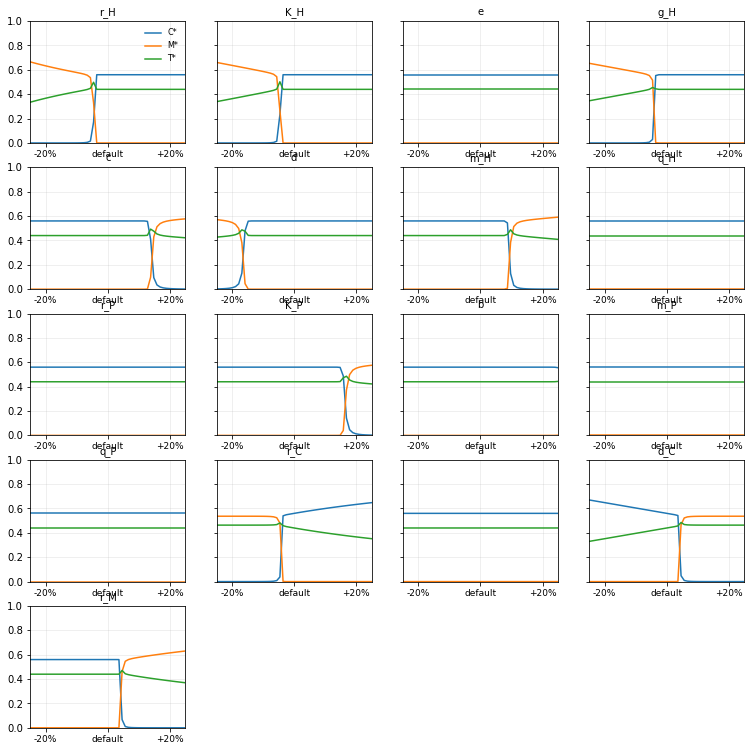

In [204]:
plot_benthic_sensitivity_small_multiples(
    results=results,
    default_params=default_params,
    latex_labels=None,     # or latex_labels if you defined it
    ncols=4,
    turf_label="T",
)


In [216]:
def plot_benthic_sensitivity_small_multiples(
    results,
    default_params,
    pct,
    latex_labels=None,
    ncols=4,
    figsize=(14, 11),      # good starting size for 17 panels
    show_legend_once=True,
    turf_label="T",
    title_wrap=14,
):
    params = list(results.keys())
    n = len(params)
    nrows = math.ceil(n / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    axs = np.array(axs).reshape(-1)

    xticks = [1 - pct, 1.0, 1 + pct]
    xticklabels = [f"-{int(pct*100)}%", "default", f"+{int(pct*100)}%"]

    for i, p in enumerate(params):
        ax = axs[i]
        data = results[p]

        x = np.array(data["param_vals"], dtype=float)
        p0 = default_params[p]
        x_rel = x / p0 if p0 != 0 else np.full_like(x, np.nan)

        ax.plot(x_rel, data["C_means"], label="C*")
        ax.plot(x_rel, data["M_means"], label="M*")
        ax.plot(x_rel, data["T_means"], label=f"{turf_label}*")

        title = latex_labels.get(p, p) if latex_labels is not None else p
        title_wrapped = "\n".join(textwrap.wrap(title, width=title_wrap))
        ax.set_title(title_wrapped, fontsize=9, pad=6)

        ax.set_xlim(1 - pct, 1 + pct)
        ax.set_ylim(0, 1)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, fontsize=8)
        ax.tick_params(axis="y", labelsize=8)

        ax.grid(True, alpha=0.25)

        if (not show_legend_once) or (show_legend_once and i == 0):
            ax.legend(fontsize=8, frameon=False, loc="best")

    # hide unused panels
    for j in range(n, len(axs)):
        axs[j].axis("off")

    # Reserve margins for global labels:
    # left=0.10 gives room for y label; bottom=0.10 gives room for x label
    plt.tight_layout(rect=[0.05, 0.05, 0.995, 0.98])

    # Global labels placed in the reserved margin space
    fig.text(0.5, 0.04, "Parameter value (relative to default)", ha="center", fontsize=12)
    fig.text(0.04, 0.5, "Final/steady benthic cover", va="center", rotation="vertical", fontsize=12)

    plt.show()

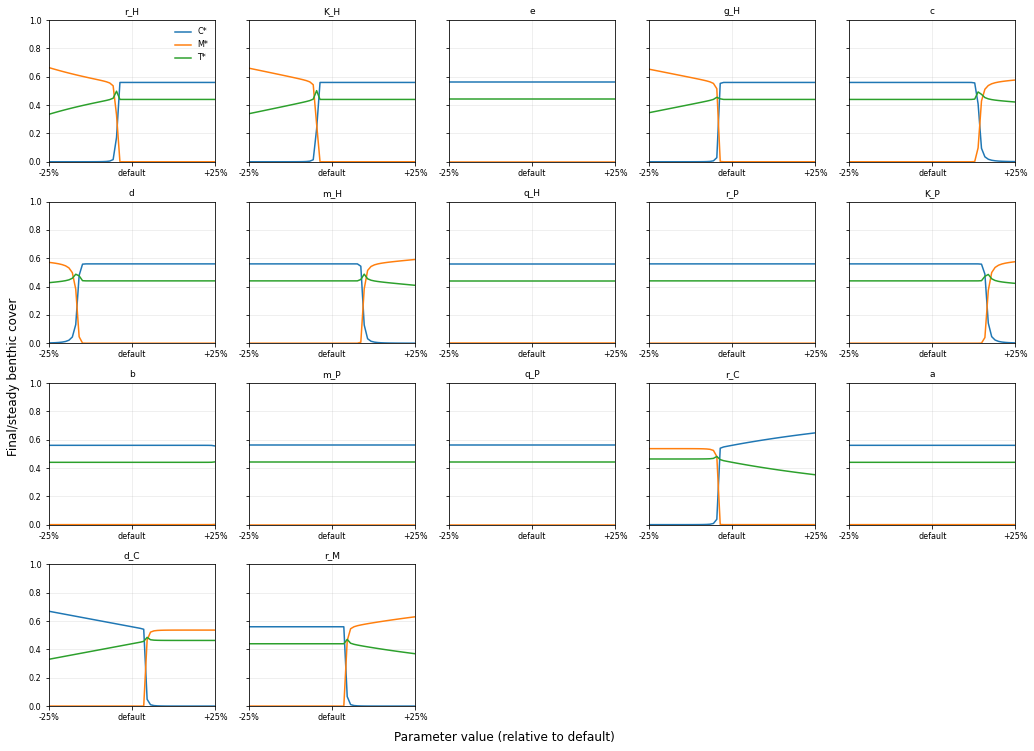

In [221]:
plot_benthic_sensitivity_small_multiples(
    results=results,
    default_params=default_params,
    pct=pct,
    latex_labels=None,
    ncols=5,
    figsize=(15, 11),
    turf_label="T",
)

In [ ]:
def compute_benthic_sensitivity_data(
    param_name,
    fixed_params,
    H0, P0, C0, M0,
    pct=0.20,
    window_years=10,
    min_cycle_amp=0.01,
    exclude_dt_numyears=True
):
    """
    Runs the model at [default*(1-pct), default, default*(1+pct)] for one parameter.
    Returns endpoints for C, M, T (turf/free space = 1-C-M).

    If the last-window amplitude is small, we store the mean as 'stable' and leave max/min as NaN.
    If oscillatory, we store max/min and leave mean as NaN (like your bifurcation convention).
    """
    params0 = fixed_params.copy()
    dt = params0["dt"]

    # convert window_years to steps
    window_steps = int(window_years / dt)
    window_steps = max(5, window_steps)  # ensure enough samples

    p_default = params0[param_name]

    # build the three values
    if p_default == 0:
        param_vals = np.array([0.0, 0.0, 0.0])
    else:
        param_vals = np.array([p_default*(1-pct), p_default, p_default*(1+pct)])

    # storage
    C_means, C_maxs, C_mins, C_cycle_center = [], [], [], []
    M_means, M_maxs, M_mins, M_cycle_center = [], [], [], []
    T_means, T_maxs, T_mins, T_cycle_center = [], [], [], []

    for val in param_vals:
        params = fixed_params.copy()
        params[param_name] = float(val)

        # run model
        H_array, P_array, C_array, M_array, *_ = run_model(H0, P0, C0, M0, params)

        # tails
        C_tail = C_array[-window_steps:]
        M_tail = M_array[-window_steps:]
        T_tail = 1.0 - C_tail - M_tail

        # amplitudes
        C_amp = np.ptp(C_tail)
        M_amp = np.ptp(M_tail)
        T_amp = np.ptp(T_tail)

        # coral
        if C_amp < min_cycle_amp:
            C_means.append(np.mean(C_tail)); C_maxs.append(np.nan); C_mins.append(np.nan); C_cycle_center.append(np.nan)
        else:
            C_means.append(np.nan); C_maxs.append(np.max(C_tail)); C_mins.append(np.min(C_tail)); C_cycle_center.append(np.mean(C_tail))

        # macroalgae
        if M_amp < min_cycle_amp:
            M_means.append(np.mean(M_tail)); M_maxs.append(np.nan); M_mins.append(np.nan); M_cycle_center.append(np.nan)
        else:
            M_means.append(np.nan); M_maxs.append(np.max(M_tail)); M_mins.append(np.min(M_tail)); M_cycle_center.append(np.mean(M_tail))

        # turf/free space
        if T_amp < min_cycle_amp:
            T_means.append(np.mean(T_tail)); T_maxs.append(np.nan); T_mins.append(np.nan); T_cycle_center.append(np.nan)
        else:
            T_means.append(np.nan); T_maxs.append(np.max(T_tail)); T_mins.append(np.min(T_tail)); T_cycle_center.append(np.mean(T_tail))

    return {
        "param_name": param_name,
        "param_default": p_default,
        "param_vals": param_vals,
        "param_rel": (param_vals / p_default) if p_default != 0 else np.array([np.nan, np.nan, np.nan]),

        "C_means": np.array(C_means), "C_maxs": np.array(C_maxs), "C_mins": np.array(C_mins), "C_cycle_center": np.array(C_cycle_center),
        "M_means": np.array(M_means), "M_maxs": np.array(M_maxs), "M_mins": np.array(M_mins), "M_cycle_center": np.array(M_cycle_center),
        "T_means": np.array(T_means), "T_maxs": np.array(T_maxs), "T_mins": np.array(T_mins), "T_cycle_center": np.array(T_cycle_center),
    }

In [25]:
def benthic_endpoints(C_array, M_array, dt, window_years=10):
    """
    Return steady-state (mean over last window) of C, M, and F (=1-C-M).
    """
    window_steps = int(window_years / dt)
    window_steps = max(1, min(window_steps, len(C_array)))  # safe

    C_tail = C_array[-window_steps:]
    M_tail = M_array[-window_steps:]
    F_tail = 1.0 - C_tail - M_tail

    return {
        "C_star": float(np.mean(C_tail)),
        "M_star": float(np.mean(M_tail)),
        "F_star": float(np.mean(F_tail)),
        "C_std":  float(np.std(C_tail)),
        "M_std":  float(np.std(M_tail)),
        "F_std":  float(np.std(F_tail)),
    }

In [26]:
def get_sensitivity_params(parameters_dict, exclude=("numyears", "dt")):
    return [k for k in parameters_dict.keys() if k not in exclude]

In [27]:
def one_at_a_time_sensitivity(
    base_params,
    H0, P0, C0, M0,
    pct=0.20,
    window_years=10,
    exclude=("numyears", "dt"),
):
    """
    For each parameter in base_params (except excluded), run:
      p_low  = p*(1-pct)
      p_base = p
      p_high = p*(1+pct)

    Returns dict keyed by param -> dict with x values and endpoint metrics.
    """
    dt = base_params["dt"]
    sens_params = get_sensitivity_params(base_params, exclude=exclude)

    results = {}

    for name in sens_params:
        p0 = base_params[name]

        # handle parameters that are 0: ±20% gives same value -> not informative
        if p0 == 0:
            vals = [0.0, 0.0, 0.0]
        else:
            vals = [p0 * (1 - pct), p0, p0 * (1 + pct)]

        endpoints = []
        for v in vals:
            params = dict(base_params)
            params[name] = v

            H, P, C, M, Hh, Ph = run_model(H0, P0, C0, M0, params)

            endpoints.append(benthic_endpoints(C, M, dt=dt, window_years=window_years))

        results[name] = {
            "param_name": name,
            "param_default": p0,
            "param_vals": vals,                 # [low, base, high]
            "endpoints": endpoints,             # list of dicts len=3
        }

    return results

In [28]:
parameters_dict["numyears"] = int(100 / parameters_dict["dt"])  # 10000 steps

sens_results = one_at_a_time_sensitivity(
    base_params=parameters_dict,
    H0=20, P0=5, C0=0.50, M0=0.50,
    pct=0.20,
    window_years=10,
    exclude=("numyears", "dt"),   # keep dt fixed
)

In [29]:
def sensitivity_to_dataframe(sens_results):
    rows = []
    for pname, info in sens_results.items():
        default = info["param_default"]
        for level, val, ep in zip(["low", "base", "high"], info["param_vals"], info["endpoints"]):
            rows.append({
                "param": pname,
                "level": level,
                "param_val": val,
                "param_rel": (val/default if default != 0 else np.nan),  # ~0.8, 1.0, 1.2
                **ep
            })
    return pd.DataFrame(rows)

df_sens = sensitivity_to_dataframe(sens_results)

### Plot

In [33]:
import math

def plot_oat_sensitivity_small_multiples(
    df_sens,
    params_order=None,
    ncols=4,
    figsize_per_panel=(3.2, 2.6),
    show_legend_once=True,
    turf_label="T",   # change to "F" if you want
):
    """
    df_sens must have columns:
      - param (str)
      - param_rel (float) ~ [0.8, 1.0, 1.2]
      - C_star, M_star, F_star
    """
    # Choose parameter order
    if params_order is None:
        params = sorted(df_sens["param"].unique())
    else:
        params = params_order

    n = len(params)
    nrows = math.ceil(n / ncols)

    fig_w = figsize_per_panel[0] * ncols
    fig_h = figsize_per_panel[1] * nrows
    fig, axs = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharex=True, sharey=True)
    axs = np.array(axs).reshape(-1)

    # x positions and labels
    x_ticks = [0.8, 1.0, 1.2]
    x_ticklabels = ["-20%", "default", "+20%"]

    for i, p in enumerate(params):
        ax = axs[i]
        sub = df_sens[df_sens["param"] == p].sort_values("param_rel")

        x = sub["param_rel"].to_numpy()

        ax.plot(x, sub["C_star"].to_numpy(), marker="o", label="C*")
        ax.plot(x, sub["M_star"].to_numpy(), marker="o", label="M*")
        ax.plot(x, sub["F_star"].to_numpy(), marker="o", label=f"{turf_label}*")

        ax.set_title(p, fontsize=10)
        ax.set_xlim(0.75, 1.25)
        ax.set_ylim(0, 1)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticklabels, fontsize=9)

        # Light grid helps readability
        ax.grid(True, alpha=0.25)

        if (not show_legend_once) or (show_legend_once and i == 0):
            ax.legend(fontsize=8, frameon=False, loc="best")

    # Turn off any unused axes
    for j in range(n, len(axs)):
        axs[j].axis("off")

    # Global labels
    fig.supxlabel("Parameter value (relative to default)", fontsize=12)
    fig.supylabel("Final/steady benthic cover", fontsize=12)

    plt.tight_layout()
    plt.show()

AttributeError: 'Figure' object has no attribute 'supxlabel'

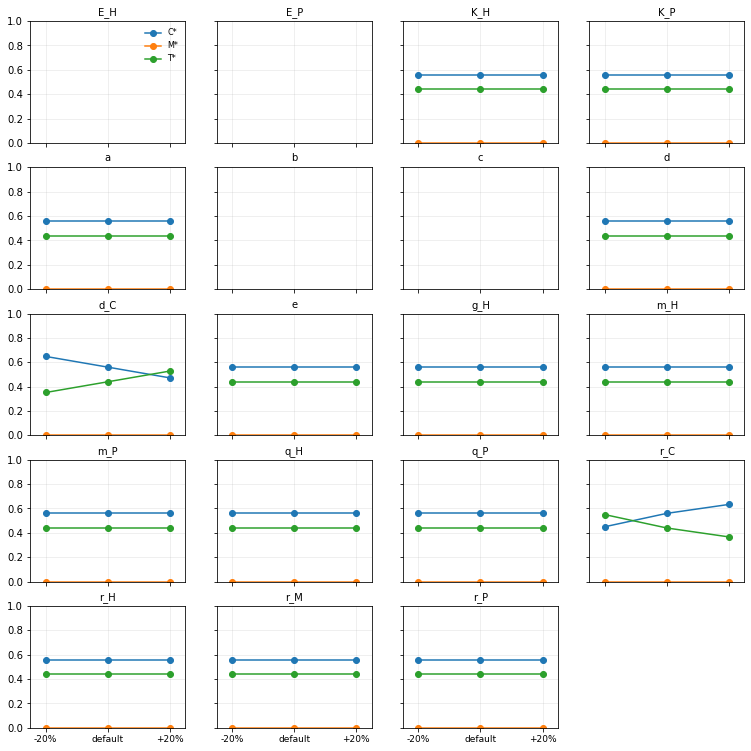

In [34]:
plot_oat_sensitivity_small_multiples(df_sens, ncols=4, turf_label="T")


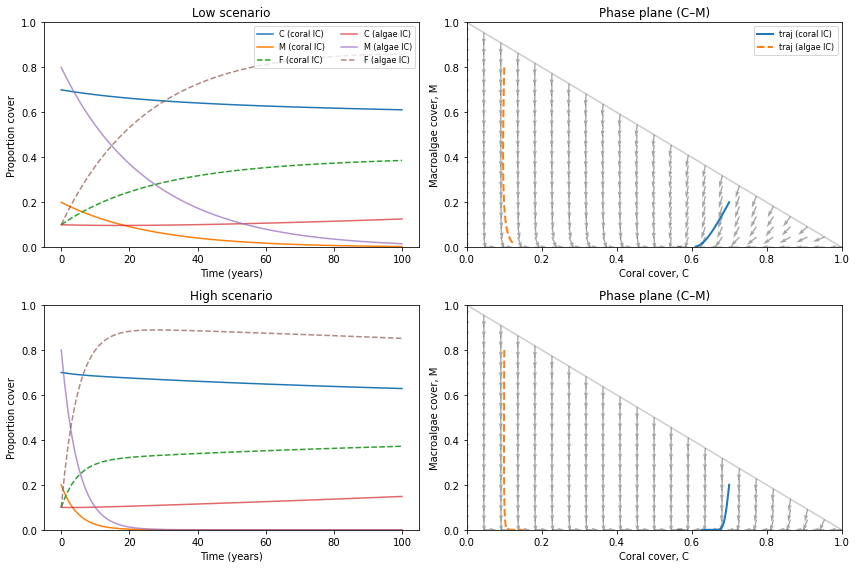

In [10]:
# ---------- Utilities ----------
def compute_F(C, M):
    return 1.0 - C - M

def last_window_mean_std(x, frac=0.25):
    n = len(x)
    i0 = int((1-frac)*n)
    return np.mean(x[i0:]), np.std(x[i0:])

def run_with_params(params, init):
    H0, P0, C0, M0 = init
    return run_model(H0, P0, C0, M0, params)

def benthic_vector_field(params, H_fixed, P_fixed, n=21):
    """
    Vector field in (C, M) space with H and P held fixed.
    This is the cleanest benthic phase-plane diagnostic given your full 4D system.
    """
    C = np.linspace(0, 1, n)
    M = np.linspace(0, 1, n)
    Cg, Mg = np.meshgrid(C, M)

    dC = np.zeros_like(Cg)
    dM = np.zeros_like(Mg)

    for i in range(n):
        for j in range(n):
            Ci = Cg[i, j]
            Mi = Mg[i, j]

            # optionally skip infeasible region C+M>1
            if Ci + Mi > 1:
                dC[i, j] = np.nan
                dM[i, j] = np.nan
                continue

            dH, dP, dCi, dMi = dNdt(H_fixed, P_fixed, Ci, Mi, params)
            dC[i, j] = dCi
            dM[i, j] = dMi

    # Normalize arrows for nicer plotting (avoid divide by 0)
    mag = np.sqrt(dC**2 + dM**2)
    mag[mag == 0] = 1.0
    dC_n = dC / mag
    dM_n = dM / mag

    return Cg, Mg, dC_n, dM_n

# ---------- Choose scenarios ----------
# You can interpret these as LOW/HIGH grazing OR LOW/HIGH fishing
low_scenario  = {"g_H": 0.2, "E_H": 0.0, "E_P": 0.0}   # example
high_scenario = {"g_H": 1.0, "E_H": 0.0, "E_P": 0.0}   # example

# If you want "low/high fishing" instead, do something like:
# low_scenario  = {"E_H": 0.0,  "E_P": 0.0}
# high_scenario = {"E_H": 0.15, "E_P": 0.0}

# ---------- Two initial conditions for bistability ----------
init_coral = (20, 5, 0.7, 0.2)  # (H0, P0, C0, M0)
init_algae = (20, 5, 0.1, 0.8)

# ---------- Base parameters ----------
base = dict(parameters_dict)  # your existing dictionary
# Make sure dt is set if you’re using it
# base["dt"] = 0.05

def make_panel(fig, ax_ts, ax_pp, params, title):
    # update params
    p = dict(base)
    p.update(params)

    numyears = p["numyears"]
    t = np.arange(numyears + 1)

    # Run both initial conditions
    H1, P1, C1, M1, _, _ = run_with_params(p, init_coral)
    H2, P2, C2, M2, _, _ = run_with_params(p, init_algae)

    F1 = compute_F(C1, M1)
    F2 = compute_F(C2, M2)

    # --- Time series panel (C, M, F) ---
    ax_ts.plot(t, C1, label="C (coral IC)")
    ax_ts.plot(t, M1, label="M (coral IC)")
    ax_ts.plot(t, F1, linestyle="--", label="F (coral IC)")

    ax_ts.plot(t, C2, alpha=0.7, label="C (algae IC)")
    ax_ts.plot(t, M2, alpha=0.7, label="M (algae IC)")
    ax_ts.plot(t, F2, linestyle="--", alpha=0.7, label="F (algae IC)")

    ax_ts.set_ylim(0, 1)
    ax_ts.set_xlabel("Time (years)")
    ax_ts.set_ylabel("Proportion cover")
    ax_ts.set_title(title)

    # --- Phase plane panel (C vs M) with vector field ---
    # Hold H,P fixed for the vector field:
    # Option 1: fix to initial H,P (simple diagnostic)
    H_fix, P_fix = init_coral[0], init_coral[1]

    Cg, Mg, dC, dM = benthic_vector_field(p, H_fixed=H_fix, P_fixed=P_fix, n=23)

    # Mask infeasible region for quiver (where NaNs)
    mask = np.isfinite(dC) & np.isfinite(dM)
    ax_pp.quiver(Cg[mask], Mg[mask], dC[mask], dM[mask], alpha=0.35)

    # Overlay trajectories
    ax_pp.plot(C1, M1, linewidth=2, label="traj (coral IC)")
    ax_pp.plot(C2, M2, linewidth=2, linestyle="--", label="traj (algae IC)")

    ax_pp.set_xlim(0, 1)
    ax_pp.set_ylim(0, 1)
    ax_pp.set_xlabel("Coral cover, C")
    ax_pp.set_ylabel("Macroalgae cover, M")
    ax_pp.set_title("Phase plane (C–M)")

    # Feasible boundary C+M=1
    x = np.linspace(0, 1, 200)
    ax_pp.plot(x, 1-x, color="k", alpha=0.2)

    return (C1, M1, C2, M2)

# ---------- Build the 2x2 figure ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

make_panel(fig, axs[0, 0], axs[0, 1], low_scenario,  title="Low scenario")
make_panel(fig, axs[1, 0], axs[1, 1], high_scenario, title="High scenario")

# Clean legend: show once
axs[0, 0].legend(fontsize=8, ncol=2, loc="upper right")
axs[0, 1].legend(fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

In [82]:
def equilibrium_from_timeseries(C_array, M_array, frac=0.25):
    n = len(C_array)
    start = int((1 - frac) * n)
    C_star = np.mean(C_array[start:])
    M_star = np.mean(M_array[start:])
    C_std  = np.std(C_array[start:])
    M_std  = np.std(M_array[start:])
    return C_star, M_star, C_std, M_std

In [83]:
def sweep_effort(param_base, effort_key, effort_values, init_1, init_2, fixed_overrides=None):
    if fixed_overrides is None:
        fixed_overrides = {}

    out = {
        "effort": [],
        "C1": [], "M1": [], "C2": [], "M2": [],
        "C1_std": [], "M1_std": [], "C2_std": [], "M2_std": [],
    }

    for f in effort_values:
        params = dict(param_base)
        params.update(fixed_overrides)
        params[effort_key] = f

        # branch 1
        H0, P0, C0, M0 = init_1
        H, P, C, M, Hh, Ph = run_model(H0, P0, C0, M0, params)
        C1, M1, C1s, M1s = equilibrium_from_timeseries(C, M)

        # branch 2
        H0, P0, C0, M0 = init_2
        H, P, C, M, Hh, Ph = run_model(H0, P0, C0, M0, params)
        C2, M2, C2s, M2s = equilibrium_from_timeseries(C, M)

        out["effort"].append(f)
        out["C1"].append(C1); out["M1"].append(M1)
        out["C2"].append(C2); out["M2"].append(M2)
        out["C1_std"].append(C1s); out["M1_std"].append(M1s)
        out["C2_std"].append(C2s); out["M2_std"].append(M2s)

    return out

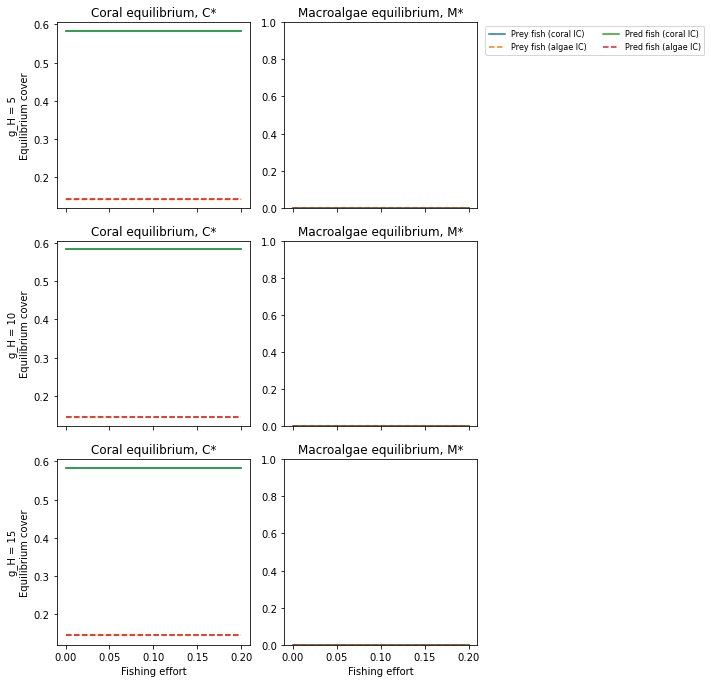

In [84]:
# choose facets (grazing levels)
gH_values = [5, 10, 15]   # example
effort_vals = np.linspace(0, 0.2, 41)

# two initial conditions for bistability probing
init_coral = (20, 5, 0.6, 0.2)
init_algae = (5,  5, 0.1, 0.8)

fig, axes = plt.subplots(len(gH_values), 2, figsize=(10, 3.2*len(gH_values)), sharex=True, sharey='col')

for r, gH in enumerate(gH_values):
    base = dict(parameters_dict)
    base["g_H"] = gH

    # prey fishing sweep (E_H varies, E_P fixed)
    prey = sweep_effort(
        base, effort_key="E_H", effort_values=effort_vals,
        init_1=init_coral, init_2=init_algae,
        fixed_overrides={"E_P": 0.0}
    )

    # predator fishing sweep (E_P varies, E_H fixed)
    pred = sweep_effort(
        base, effort_key="E_P", effort_values=effort_vals,
        init_1=init_coral, init_2=init_algae,
        fixed_overrides={"E_H": 0.0}
    )

    axC = axes[r, 0]
    axM = axes[r, 1]

    # Coral equilibrium
    axC.plot(prey["effort"], prey["C1"], label="Prey fish (coral IC)")
    axC.plot(prey["effort"], prey["C2"], linestyle="--", label="Prey fish (algae IC)")
    axC.plot(pred["effort"], pred["C1"], label="Pred fish (coral IC)")
    axC.plot(pred["effort"], pred["C2"], linestyle="--", label="Pred fish (algae IC)")

    # Macroalgae equilibrium
    axM.plot(prey["effort"], prey["M1"], label="Prey fish (coral IC)")
    axM.plot(prey["effort"], prey["M2"], linestyle="--", label="Prey fish (algae IC)")
    axM.plot(pred["effort"], pred["M1"], label="Pred fish (coral IC)")
    axM.plot(pred["effort"], pred["M2"], linestyle="--", label="Pred fish (algae IC)")

    axC.set_ylabel(f"g_H = {gH}\nEquilibrium cover")
    axC.set_title("Coral equilibrium, C*")
    axM.set_title("Macroalgae equilibrium, M*")
    axM.set_ylim(0, 1)

axes[-1, 0].set_xlabel("Fishing effort")
axes[-1, 1].set_xlabel("Fishing effort")

# put legend once (top row, right panel, or outside)
axes[0, 1].legend(fontsize=8, ncol=2, loc="upper left", bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()